# 3B. PSF modeling and subtraction (with object-oriented modules)

> Authors: *Valentin Christiaens* and *Thomas Bédrine*  
> Suitable for VIP *v1.4.0* onwards  
> Last update: *2023/03/17*

**Table of contents**

* [3.1. Important features needed for the PSF subtraction classes](#3.1.-Important-features-needed-for-the-PSF-subtraction-classes)
    - [3.1.1. General tools for all post-processing classes](#3.1.1.-General-tools-for-all-post-processing-classes)
    - [3.1.2. Loading the ADI data with a Dataset object](#3.1.2.-Loading-the-ADI-data-with-a-Dataset-object)
* [3.2. median-ADI](#3.2.-median-ADI)
* [3.3. Pairwise frame difference](#3.3.-Pairwise-frame-difference)
* [3.4. Least-squares approximation (LOCI)](#3.4.-Least-squares-approximation-(LOCI))
* [3.5. Principal Component Analysis (PCA)](#3.5.-Principal-Component-Analysis-(PCA))
    - [3.5.1. Full-frame PCA](#3.5.1.-Full-frame-PCA)
    - [3.5.2. Optimizing the number of PCs for full-frame PCA-ADI](#3.5.2.-Optimizing-the-number-of-PCs-for-full-frame-PCA-ADI)
    - [3.5.3. Full-frame  PCA-ADI with a parallactic angle threshold](#3.5.3.-Full-frame-PCA-ADI-with-a-parallactic-angle-threshold)
    - [3.5.4. PCA for big datacubes](#3.5.4.-PCA-for-big-datacubes)
    - [3.5.5. Annular PCA](#3.5.5.-Annular-PCA)
    - [3.5.6. PCA in a single annulus](#3.5.6.-PCA-in-a-single-annulus)
* [3.6. Non-negative Matrix Factorization (NMF)](#3.6.-Non-negative-Matrix-Factorization-(NMF))
    - [3.6.1. Full-frame NMF](#3.6.1.-Full-frame-NMF)
    - [3.6.2. Annular NMF](#3.6.2.-Annular-NMF)
* [3.7. Local Low-rank plus Sparse plus Gaussian-noise decomposition (LLSG)](#3.7.-Local-Low-rank-plus-Sparse-plus-Gaussian-noise-decomposition-(LLSG))
* [3.8. ANgular Differential OptiMal Exoplanet Detection Algorithm (ANDROMEDA)](#3.8.-ANgular-Differential-OptiMal-Exoplanet-Detection-Algorithm-(ANDROMEDA))
* [3.9. Forward-Model Matched Filter (FMMF)](#3.9.-Forward-Model-Matched-Filter-(FMMF))
* [3.10. Patch Covariances (PACO)](#3.10.-Patch-Covariances-(PACO))
* [3.11. Summary mosaic](#3.11.-Summary-mosaic)

This tutorial shows:

- how to use the stellar PSF subtraction algorithms already presented in the [3A - PSF Modeling and subtraction](./03A_psfsub.ipynb) tutorial, in an object-oriented approach.
- how to save images obtained through those algorithms and the parameters used to get them.

-----------

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from multiprocessing import cpu_count
import numpy as np
from packaging import version
from dataclass_builder import update

In the following box we import all the VIP routines that will be used in this tutorial.
We will need version 1.4.0 or above to run the tutorials, otherwise we would miss a large part of the recent object-oriented support.

In [2]:
import vip_hci as vip
vvip = vip.__version__
print(f"VIP version: {vvip}")
if version.parse(vvip) < version.parse("1.4.0"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.4.0 or above to run this notebook."
    raise ValueError(msg)

from vip_hci.invprob import fmmf, FastPACO, andromeda
from vip_hci.config import VLT_NACO
from vip_hci.fm import normalize_psf
from vip_hci.metrics import inverse_stim_map, stim_map, significance, snr, snrmap
from vip_hci.psfsub import (llsg, median_sub, nmf, nmf_annular,
                            pca, pca_annular, pca_annulus, pca_grid)
from vip_hci.fits import open_fits, write_fits, info_fits
from vip_hci.var import fit_2dgaussian, frame_center
from vip_hci.objects import (PostProc, PPResult, ALL_SESSIONS, MedianBuilder, FrameDiffBuilder, LOCIBuilder,
                             PCABuilder, NMFBuilder, LLSGBuilder)

VIP version: 1.4.0


## 3.1. Important features needed for the PSF subtraction classes

### 3.1.1. General tools for all post-processing classes

First of all, every post-processing class we will see here inherit from the `PostProc` class, which gives most of the required material to function properly. However, we shall not instantiate this class because it doesn't implement any algorithm and only serves as a model for every other object. Instead, we will instantiate the inherited classes directly.

The `PostProc` class still does several important tasks :

- identify the attributes that will need to be calculated (typically, the corrected frames or the signal-to-noise ratio maps)
- calculate the signal-to-noise ratio maps from the corrected frame
- set up the needed parameters for each algorithm function.

In order to take full advantage of the object-oriented support, we will also include a container for all the results we get with every object : `PPResult`. This object stores as many sets of parameters and their corrected frame as we wish, and can also hold the associated signal-to-noise ratio map if we generate one. The purpose of this is to facilitate the analysis of the data treated and to allow to save them for later use.

All these points will be illustrated in several examples as we go on the tutorial, and are part of what we want to do when using object-oriented modules.

### 3.1.2. Loading the ADI data with a Dataset object

For this tutorial, we will make use of the ADI cube and its associated PSF seen in the first half of this tutorial : [3A - PSF Modeling and subtraction](./03A_psfsub.ipynb). 

More info on this dataset, and on opening and visualizing fits files with VIP in general, is available in Tutorial [1 - Quick start](./01_quickstart.ipynb).

First, we need to load the ADI data as a Dataset object, or open a previously saved Dataset object. More info on how to create a proper Dataset object is available in Tutorial [9 - Using Dataset objects](./09_datasets_as_objects.ipynb).

Let's load the datacube, associated parallactic angles and non-coronagraphic PSF:

In [3]:
betapic = vip.Dataset(cube='../datasets/naco_betapic_cube_cen.fits',
                     angles='../datasets/naco_betapic_pa.fits',
                     psf='../datasets/naco_betapic_psf.fits')

Cube array shape: (61, 101, 101)
Angles array shape: (61,)
PSF array shape: (39, 39)


Let's not forget to perform additionnal operations on the Dataset and setup useful parameters to obtain the same results as in 3A.

In [4]:
derot_off = 104.84 # NACO derotator offset for this observation (Absil et al. 2013)
TN = -0.45         # Position angle of true north for NACO at the epoch of observation (Absil et al. 2013)
betapic.angles -= derot_off+TN

betapic.normalize_psf(size=19)
betapic.px_scale = VLT_NACO["plsc"]

imlib_rot = 'vip-fft'
interpolation=None


Mean FWHM: 4.801
Flux in 1xFWHM aperture: 1.307
Normalized PSF array shape: (19, 19)
The attribute `psfn` contains the normalized PSF
`fwhm` attribute set to
4.801


Let's visualize the normalized PSF with `hciplot.plot_frames`. Feel free to adapt the `backend` argument throughout the notebook: `'matplotlib'` (default) allows paper-quality figures with annotations which can be saved (default), while `'bokeh'` enables interactive visualization.

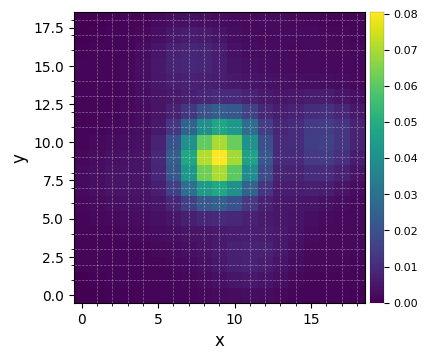

In [5]:
plot_frames(betapic.psfn, grid=True, size_factor=4)

The Dataset object was loaded successfully and matches the results we had so far in 3A. We are now ready to use the PSF subtraction algorithms objects.

## 3.2 median-ADI as a first-hand example

In the 3A section of the tutorial, we saw how every algorithm worked and how to use their associated functions. To avoid as much dupe explanations as possible, we will focus on the sole purpose of using the objects. We highly recommend to read closely the 3A section for details about all the base algorithm methods seen here.

We will also spend some time presenting as much functionnalities as possible, so later examples can go as quick and easy as possible.

### 3.2.1. Full-frame median-ADI

Let's start with the median substraction algorithm, in full-frame mode. We will go through several tools here, but we will cover them in detail. First, we can create an instance of `PPResult` to hold the results we will obtain through the median subtraction object. That same instance can hold results from any algorithm and register the name of the function used, so you can reuse the same object for each of them.

In [6]:
results = PPResult()

Note that this step is optional, if we do not particularly want to store the results, then no instance is required for the use of any post-processing object. It is however quite recommended, as the `PPResult` class offers a built-in function dedicated to frame-plotting - although we can still use the `plot_frames` function.

Now for the actual initialization of the median subtraction object, we will make use of a builder. A builder is an object-oriented concept that permits the initialization of an object in several steps. Let's take a look at how it works :

In [7]:
medsub_builder = MedianBuilder(dataset=betapic, mode='fullfr', results=results)
medsub_builder.imlib = imlib_rot
medsub_builder.interpolation = interpolation

medsub_obj = medsub_builder.build()

Here, we fractionned the creation of the object in four separate lines, to show that we can add any parameter at any point, as long as we do it before we actually `build` the object. This is useful if we ever need some parameters that are not defined yet. However, in practice we will most likely have all the parameters we need for the algorithm so we can speed up the process and shorten everything in one line :

In [8]:
medsub_obj = MedianBuilder(dataset=betapic, mode='fullfr', imlib=imlib_rot, interpolation=interpolation,
                          results=results).build()

The object obtained is called a `PPMedianSub`, an object that inherits the `PostProc` class and therefore its built-in functions. Notably, we can check if every parameter is correct in the `medsub_obj` by using the function `print_parameters` :

In [9]:
medsub_obj.print_parameters()

dataset : <vip_hci.objects.dataset.Dataset object at 0x7fb407018a60>
verbose : True
results : PPResult(sessions=[])
frame_final : None
flux_sc_list : None
radius_int : 0
asize : 4
delta_rot : 1
delta_sep : (0.1, 1)
mode : fullfr
nframes : 4
sdi_only : False
imlib : vip-fft
interpolation : None
collapse : median
_algo_name : median_sub
cube_residuals : None
cube_residuals_der : None


There are a lot of parameters here that we didn't give to the builder : those are the default values of the object. It contains both all the variables that need to be passed to the function of the median subtraction algorithm, and the variables we will get as a result of that function. The most important one is `frame_final`, which is the corrected frame obtained after treating the data. This attribute is common to every post-processing object and is obtained after a `run` of that said object.

Now that the object has been successfully created, we can execute the `run` function. This function can take optional parameters, such as a Dataset - if we did not give one yet, or if we want to change it - or the number of processes dedicated to the execution of algorithm (`nproc`).

In [10]:
medsub_obj.run()

No changes were made to the dataset.
The following parameters will be used for the run of median_sub :
- verbose : True
- flux_sc_list : None
- radius_int : 0
- asize : 4
- delta_rot : 1
- delta_sep : (0.1, 1)
- mode : fullfr
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- cube : np.ndarray (not shown)
- angle_list : np.ndarray (not shown)
- fwhm : 4.800919383969432
- scale_list : None
- nproc : 1
- full_output : True
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-03-24 14:41:54
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:03.672859
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
These attributes were just calculated:
	cube_residuals
	cube_residuals_der
	frame_final
The following attributes can be calculated now:
	snr_map	with .make_snrm

We got several results from this `run`, including our corrected frame named `frame_final`, or the residuals of the ADI cube (unchanged and derotated). The available attributes may change depending on the type of algorithm used, but we will always find `frame_final` as the expected main result. Also, the set of parameters used and the frame obtained had been automatically registered in the `PPResult` object, and may be shown by using the function `show_session_results`. We will take a look at this one after computing the SNR map :

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-03-24 14:41:57
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


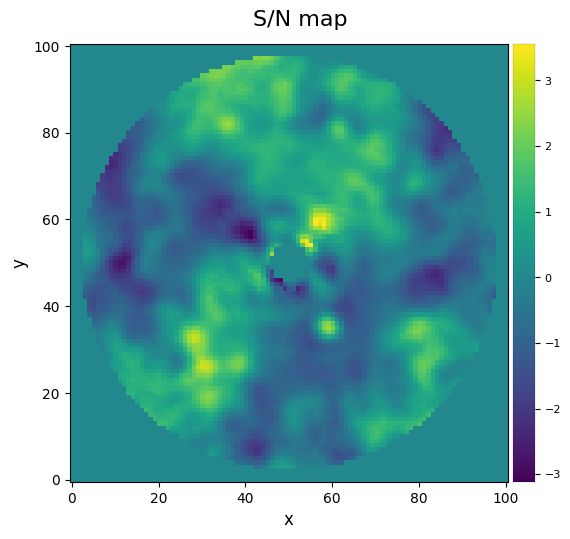

S/N map created using 2 processes
Running time:  0:00:11.497286
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [11]:
medsub_obj.make_snrmap(plot=True)#, backend='bokeh')

Now, the set of parameters, the frame and the map are all three registered in the results. If we use a different set of parameters and launch another `run`, a new entry will be made for that new set and results. 

We can access them with the `show_session_results` and the parameters `session_id` and `label`. The first one is the ID (minus 1) of the session of treatment you want to see. By default, it shows the last results you obtained, but you can ask for a specific one. The `label` defines which label you want to put on the frames. It can be a boolean (`True` prints a default label, `False` prints nothing) or a tuple of strings, which will be the label for the corrected frame and the S/N map.

It is also possible to access and print the `frame_final` and the `snr_map` with the usual `plot_frames` function, and it is recommend if you want to create images for scientific paper, as `plot_frames` can take a lot a specific parameters dedicated to customization.

Parameters used for the last session (function used : median_sub) : 
- verbose : True
- flux_sc_list : None
- radius_int : 0
- asize : 4
- delta_rot : 1
- delta_sep : (0.1, 1)
- mode : fullfr
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- fwhm : 4.800919383969432
- scale_list : None
- nproc : 1
- full_output : True


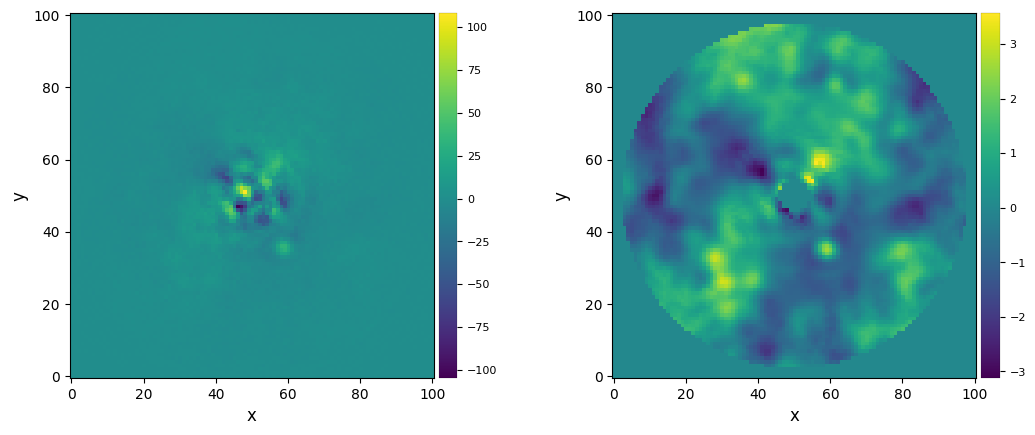

In [12]:
results.show_session_results(label=False)

### 3.2.2. Smart median-ADI

Now let's try another approach of the median subtraction algorithm. In the 3A tutorial, we ran the `median_sub` function another time with different parameters. What we will do here is no further away from that, although we already have an existing `medsub_obj` with valid parameters that can remain unchanged. We will then benefit from the object and execute another `run` while adding new parameters.

We can use the `update` function, which takes the object to update as the first parameter, and a corresponding builder with the wanted parameters as the second one. This will add the desired values to our existing object, and now we are able to `run` immediately with these new parameters :

In [13]:
update(medsub_obj, MedianBuilder(asize=betapic.fwhm, mode='annular', delta_rot=0.5, radius_int=4, nframes=4))
medsub_obj.run()

No changes were made to the dataset.
The following parameters will be used for the run of median_sub :
- verbose : True
- flux_sc_list : None
- radius_int : 4
- asize : 4.800919383969432
- delta_rot : 0.5
- delta_sep : (0.1, 1)
- mode : annular
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- cube : np.ndarray (not shown)
- angle_list : np.ndarray (not shown)
- fwhm : 4.800919383969432
- scale_list : None
- nproc : 1
- full_output : True
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-03-24 14:42:09
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 9, FWHM = 4.800919383969432
Processing annuli:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Optimized median psf reference subtracted
Done derotating and combining
Running time:  0:00:03.695249
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Our previously generated `frame_final` has been overwritten by the new run, although it was still registered in `mesdub_res` in the first entry. We should keep in mind that the object itself only holds one configuration, one frame and one map at a time, but the `PPResult` objects will save each of them :

Parameters used for the session n°1 (function used : median_sub) : 
- verbose : True
- flux_sc_list : None
- radius_int : 0
- asize : 4
- delta_rot : 1
- delta_sep : (0.1, 1)
- mode : fullfr
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- fwhm : 4.800919383969432
- scale_list : None
- nproc : 1
- full_output : True


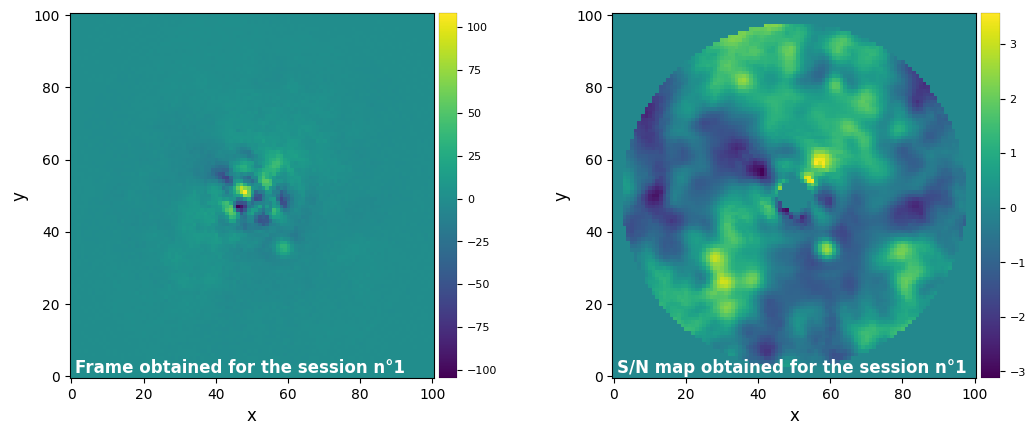

Parameters used for the session n°2 (function used : median_sub) : 
- verbose : True
- flux_sc_list : None
- radius_int : 4
- asize : 4.800919383969432
- delta_rot : 0.5
- delta_sep : (0.1, 1)
- mode : annular
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- fwhm : 4.800919383969432
- scale_list : None
- nproc : 1
- full_output : True


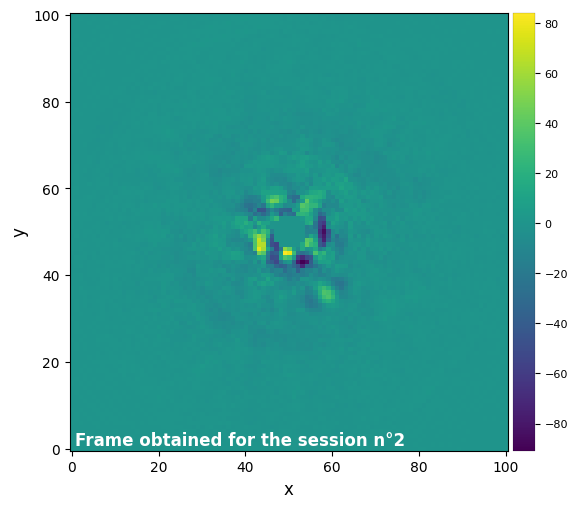

In [14]:
results.show_session_results(session_id=ALL_SESSIONS)

We can include the `snr_map` of the annular version of median subtraction :

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-03-24 14:42:14
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 2 processes
Running time:  0:00:10.678794
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Parameters used for the session n°1 (function used : median_sub) : 
- verbose : True
- flux_sc_list : None
- radius_int : 0
- asize : 4
- delta_rot : 1
- delta_sep : (0.1, 1)
- mode : fullfr
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- fwhm : 4.800919383969432
- scale_list : None
- nproc : 1
- full_output : True


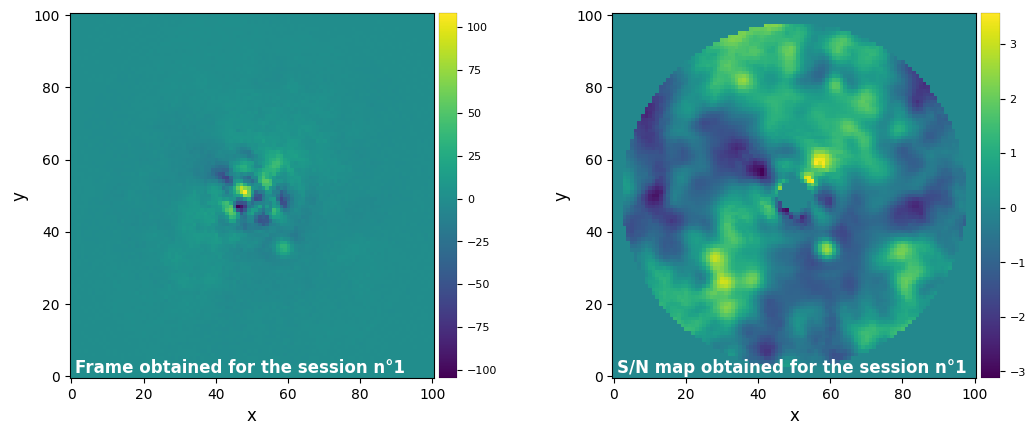

Parameters used for the session n°2 (function used : median_sub) : 
- verbose : True
- flux_sc_list : None
- radius_int : 4
- asize : 4.800919383969432
- delta_rot : 0.5
- delta_sep : (0.1, 1)
- mode : annular
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- fwhm : 4.800919383969432
- scale_list : None
- nproc : 1
- full_output : True


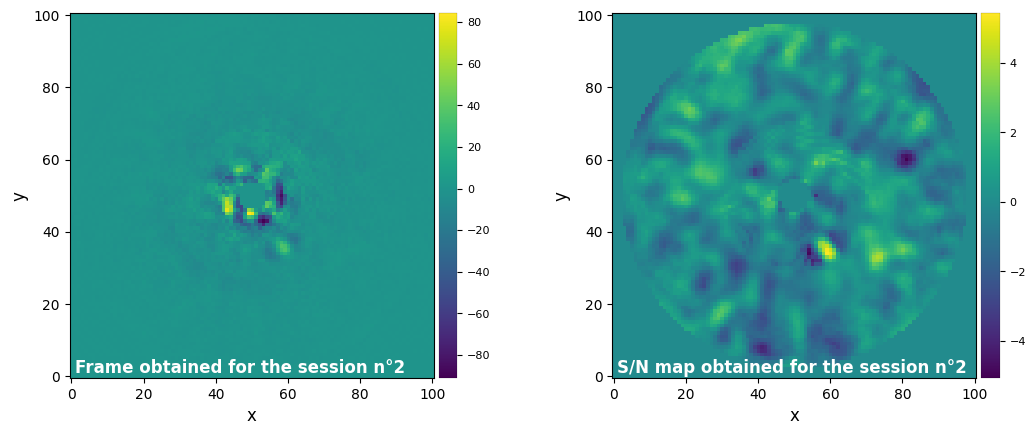

In [15]:
medsub_obj.make_snrmap()
results.show_session_results(session_id=ALL_SESSIONS)

One last tool we may use is the function `get_params_from_results`, which allows us to copy back a previously registered set of parameters into our object. Note that we cannot load a configuration that doesn't match the algorithm we are working with.

In [16]:
medsub_obj.get_params_from_results(session_id=0)

Configuration loaded :
- verbose : True
- flux_sc_list : None
- radius_int : 0
- asize : 4
- delta_rot : 1
- delta_sep : (0.1, 1)
- mode : fullfr
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- fwhm : 4.800919383969432
- scale_list : None
- nproc : 1
- full_output : True


## 3.3. Pairwise frame difference

Let's see the case of the frame differencing algorithm, with its object tools :

In [17]:
frame_diff_obj = FrameDiffBuilder(dataset=betapic, metric='l1', dist_threshold=90, delta_rot=0.5, 
                      radius_int=4, asize=betapic.fwhm, nproc=None, imlib=imlib_rot, 
                      interpolation=interpolation, verbose=True, results=results).build()
frame_diff_obj.run()

No changes were made to the dataset.
The following parameters will be used for the run of frame_diff :
- verbose : True
- metric : l1
- dist_threshold : 90
- n_similar : None
- delta_rot : 0.5
- radius_int : 4
- asize : 4.800919383969432
- ncomp : None
- imlib : vip-fft
- interpolation : None
- collapse : median
- nproc : 1
- cube : np.ndarray (not shown)
- angle_list : np.ndarray (not shown)
- fwhm : 4.800919383969432
- full_output : True
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-03-24 13:17:53
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
9 annuli. Performing pair-wise subtraction:
Ann 1    PA thresh: 21.24    Ann center:   6    N segments: 1 
Ann 2    PA thresh: 12.23    Ann center:  11    N segments: 1 
Ann 3    PA thresh:  8.58    Ann center:  16    N segments: 1 
Ann 4    PA thresh:  6.60    Ann center:  21    N segments: 1 
Ann 5    PA thresh:  5.37    Ann center:  26    N segments: 1 



Let's vizualize the final image with `plot_frames` this time:

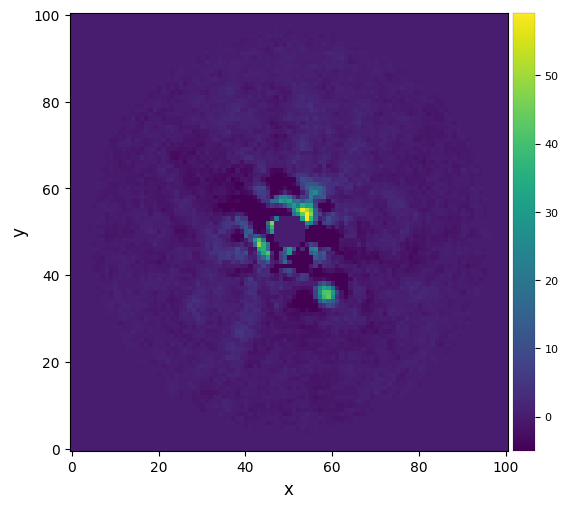

In [18]:
plot_frames(frame_diff_obj.frame_final, vmin=-5)

## 3.4. Least-squares approximation (LOCI)

Now, another example with LOCI :

In [7]:
loci_obj = LOCIBuilder(dataset=betapic, asize=betapic.fwhm, n_segments='auto', nproc=None, 
                 metric='correlation', dist_threshold=90, delta_rot=0.1, optim_scale_fact=2,
                 solver='lstsq', tol=0.01, imlib=imlib_rot, interpolation=interpolation, results= results).build()
loci_obj.run()

No changes were made to the dataset.
The following parameters will be used for the run of xloci :
- verbose : True
- metric : correlation
- dist_threshold : 90
- delta_rot : 0.1
- delta_sep : (0.1, 1)
- radius_int : 0
- asize : 4.800919383969432
- n_segments : auto
- solver : lstsq
- nproc : 1
- tol : 0.01
- optim_scale_fact : 2
- adimsdi : skipadi
- imlib : vip-fft
- interpolation : None
- collapse : median
- cube : np.ndarray (not shown)
- angle_list : np.ndarray (not shown)
- fwhm : 4.800919383969432
- scale_list : None
- full_output : True
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-03-24 13:20:16
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Building 10 annuli:
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 2 
Ann 2    PA thresh:  3.82    Ann center:   7    N segments: 3 
Ann 3    PA thresh:  2.29    Ann center:  12    N segments: 5 
Ann 4    PA thresh:  1.64    Ann center:  17


Let's vizualize the final image:

Parameters used for the last session (function used : xloci) : 
- verbose : True
- metric : correlation
- dist_threshold : 90
- delta_rot : 0.1
- delta_sep : (0.1, 1)
- radius_int : 0
- asize : 4.800919383969432
- n_segments : auto
- solver : lstsq
- nproc : 1
- tol : 0.01
- optim_scale_fact : 2
- adimsdi : skipadi
- imlib : vip-fft
- interpolation : None
- collapse : median
- fwhm : 4.800919383969432
- scale_list : None
- full_output : True


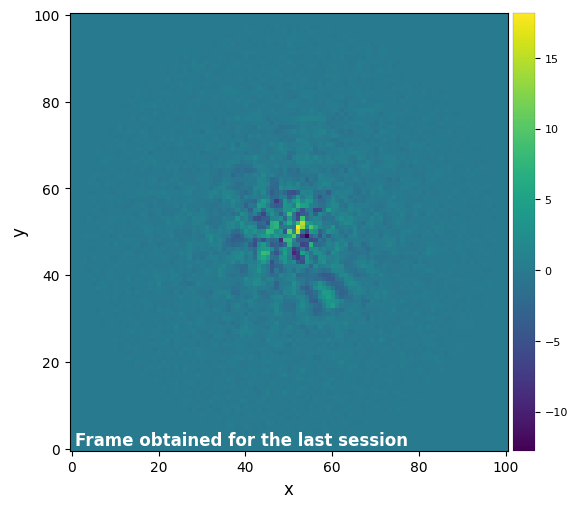

In [9]:
results.show_session_results()

This time the residuals are better subtracted. But the companion candidate also suffers significant self-subtraction. Note as well the comparatively longer processing time.

## 3.5. Principal Component Analysis (PCA)

### 3.5.1. Full-frame PCA

Now let's try the Principal Component Analysis (PCA)-based algorithms ([Amara & Quanz 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.427..948A/abstract), [Soummer et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...755L..28S/abstract)) in `vip.pca`. As a reminder, below is a schematics summarizing how full-frame PCA-ADI works: 

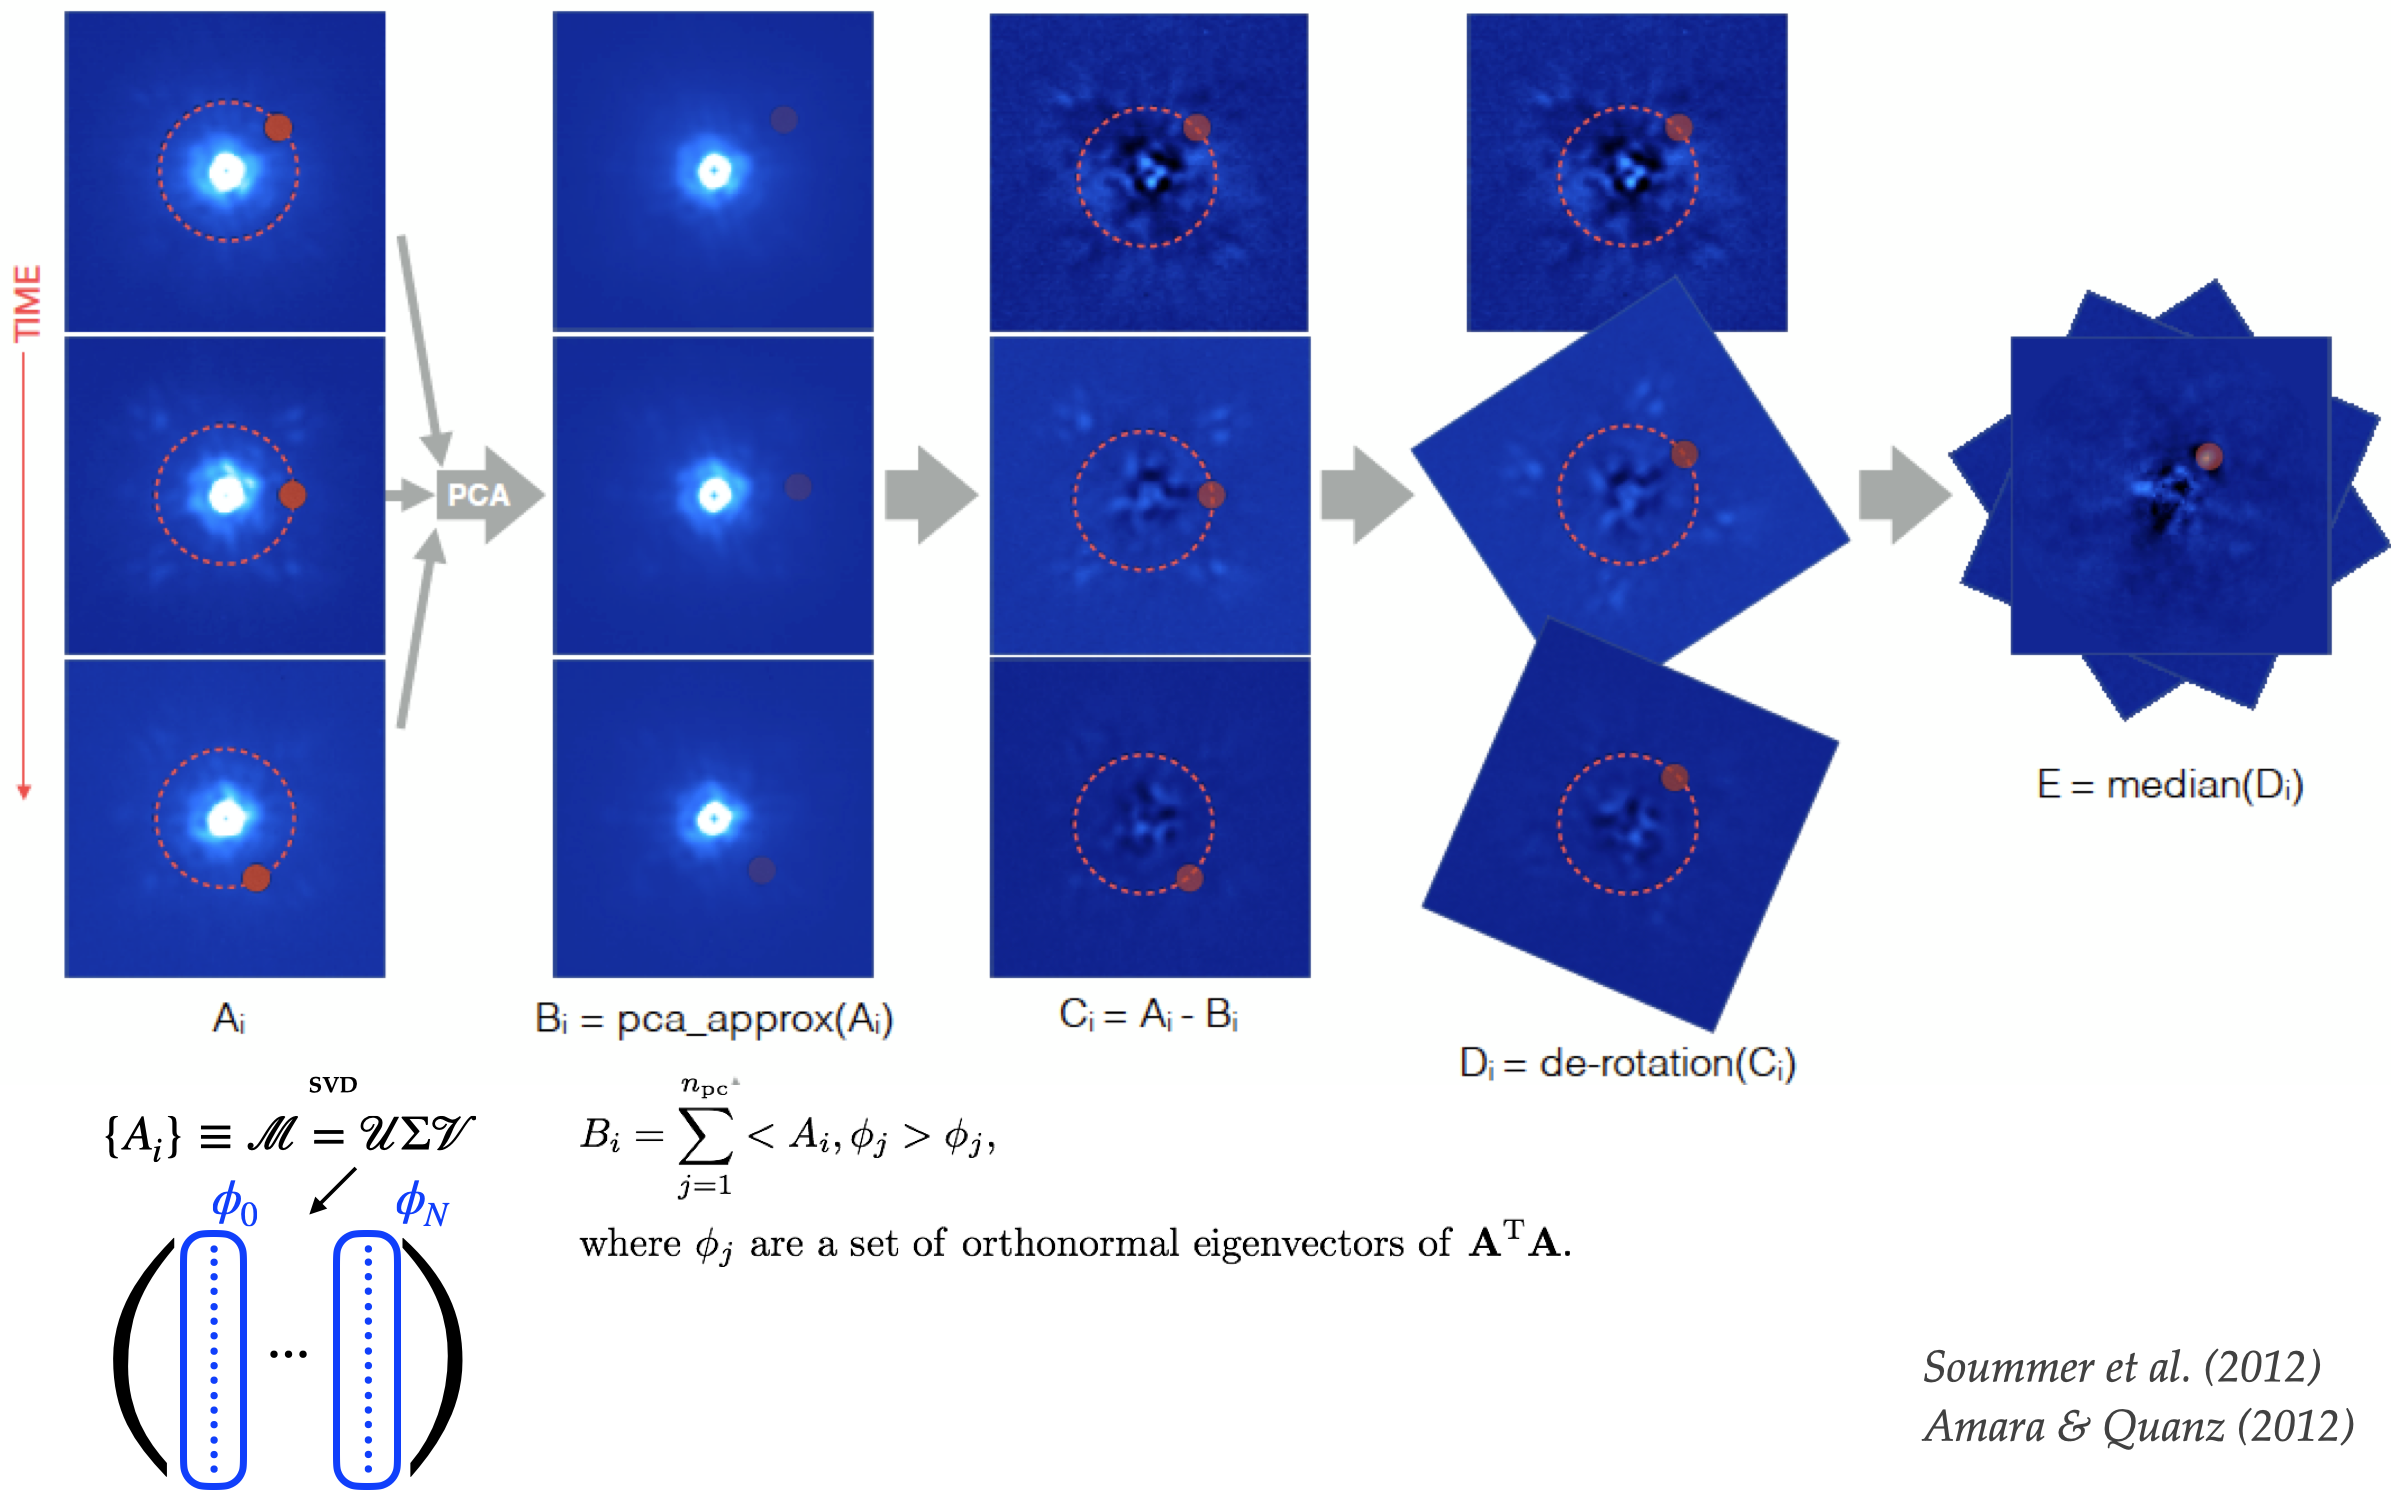

**Figure 3.2** - PCA-ADI concept. Compared to median-ADI (Fig. 3.1), only the model used for subtraction is refined. It is constructed from the projection of each image on the first $n_{\rm pc}$ principal components. The principal components are typically found by singular value decomposition, after converting the observed sequence of images $A_i$ into a 2D matrix (rows: time dimension, columns: linearized version of the images).

Let's set to 5 the number of principal components `ncomp` considered for model creation, and let's run the PCA algorithm (feel free to test other values):

In [17]:
ncomp = 5
pca_obj = PCABuilder(dataset=betapic, ncomp=ncomp, mask_center_px=None, imlib=imlib_rot, interpolation=interpolation,
              svd_mode='lapack', results=results).build()
pca_obj.run()

No changes were made to the dataset.
The following parameters will be used for the run of pca :
- verbose : True
- ncomp : 5
- svd_mode : lapack
- scaling : None
- delta_rot : 1
- imlib : vip-fft
- interpolation : None
- collapse : median
- collapse_ifs : mean
- ifs_collapse_range : all
- weights : None
- cube_sig : None
- mask_center_px : None
- source_xy : None
- adimsdi : double
- crop_ifs : True
- imlib2 : vip-fft
- mask_rdi : None
- batch : None
- conv : False
- nproc : 1
- cube : np.ndarray (not shown)
- angle_list : np.ndarray (not shown)
- cube_ref : None
- fwhm : 4.800919383969432
- scale_list : None
- full_output : True
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-03-24 14:26:51
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 25.060 GB
System available memory = 18.862 GB
Done vectorizing the frames. Matrix shape: (61, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Runni

The `svd_mode` argument sets how the Singular Value Decomposition should be calculated. 'lapack' is the default mode (exact SVD calculation by CPU through `numpy`), although other options may get faster results depending on input matrix and your machine (see description of `svd_mode` argument).

Let's visualize the final image. This time let's set the `grid` option on, to better read coordinates from the image:

In [18]:
pca_obj.make_snrmap()

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-03-24 14:26:55
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 2 processes
Running time:  0:00:09.934629
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Parameters used for the session n°1 (function used : median_sub) : 
- verbose : True
- flux_sc_list : None
- radius_int : 0
- asize : 4
- delta_rot : 1
- delta_sep : (0.1, 1)
- mode : fullfr
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- fwhm : 4.800919383969432
- scale_list : None
- nproc : 1
- full_output : True


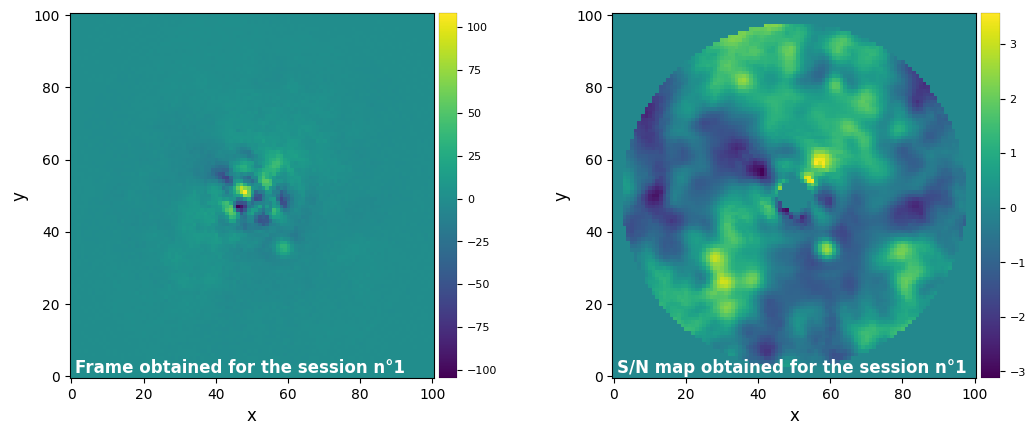

Parameters used for the session n°2 (function used : median_sub) : 
- verbose : True
- flux_sc_list : None
- radius_int : 4
- asize : 4.800919383969432
- delta_rot : 0.5
- delta_sep : (0.1, 1)
- mode : annular
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- fwhm : 4.800919383969432
- scale_list : None
- nproc : 1
- full_output : True


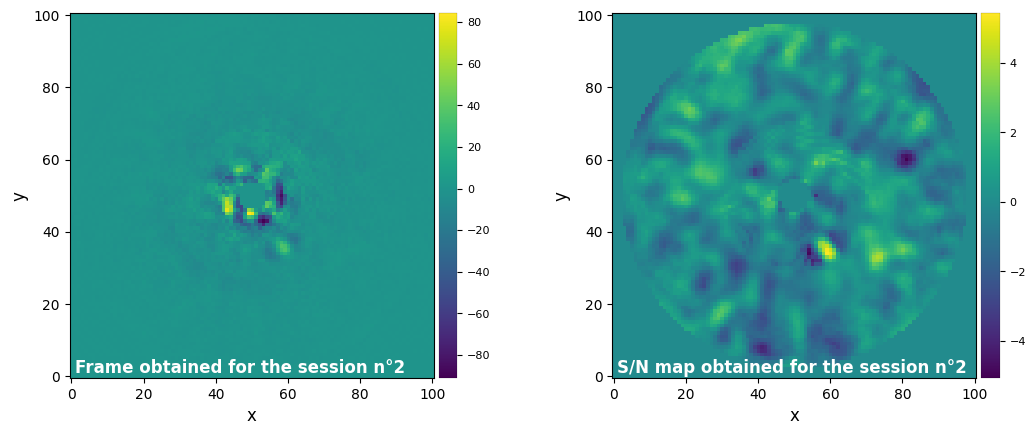

Parameters used for the session n°3 (function used : pca) : 
- verbose : True
- ncomp : 5
- svd_mode : lapack
- scaling : None
- delta_rot : 1
- imlib : vip-fft
- interpolation : None
- collapse : median
- collapse_ifs : mean
- ifs_collapse_range : all
- weights : None
- cube_sig : None
- mask_center_px : None
- source_xy : None
- adimsdi : double
- crop_ifs : True
- imlib2 : vip-fft
- mask_rdi : None
- batch : None
- conv : False
- nproc : 1
- cube_ref : None
- fwhm : 4.800919383969432
- scale_list : None
- full_output : True


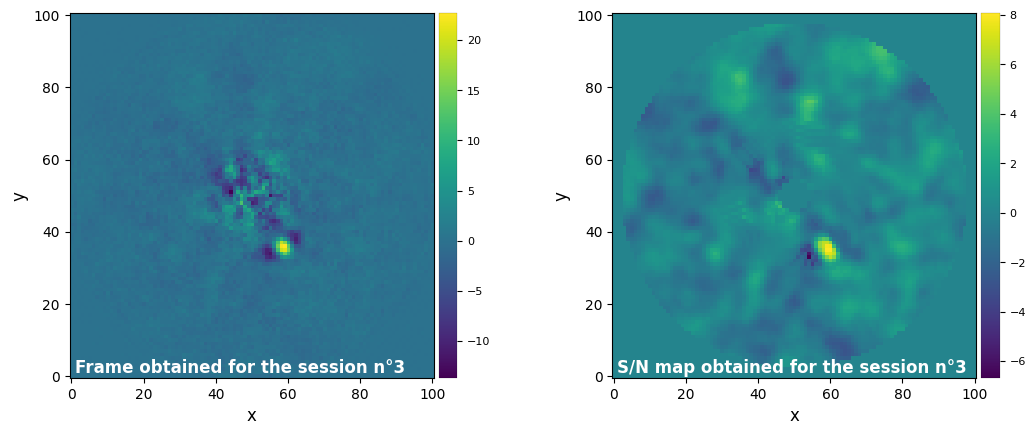

In [19]:
results.show_session_results(session_id=ALL_SESSIONS)

The improvement is clear compared to previous reductions. Very low residuals are seen near the star, and the companion candidate appears as a bright point source surrounded by negative side-lobes. The procedure is also 15-20x faster than LOCI.

In [20]:
pca_obj.get_params_from_results(session_id=-1)

Configuration loaded :
- verbose : True
- ncomp : 5
- svd_mode : lapack
- scaling : None
- delta_rot : 1
- imlib : vip-fft
- interpolation : None
- collapse : median
- collapse_ifs : mean
- ifs_collapse_range : all
- weights : None
- cube_sig : None
- mask_center_px : None
- source_xy : None
- adimsdi : double
- crop_ifs : True
- imlib2 : vip-fft
- mask_rdi : None
- batch : None
- conv : False
- nproc : 1
- cube_ref : None
- fwhm : 4.800919383969432
- scale_list : None
- full_output : True


<font color=orange> **Question 3.6**: What is the origin of the negative side lobes? </font>
    
<font color=orange> **Question 3.7**: Are they always expected to be symmetric? </font>

Now let's see whether the candidate is significant. For that let's first set the x,y coordinates of the test point source based on the above image:

In [21]:
xy_b = (58.5, 35.5)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-03-24 13:55:08
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


TypeError: `known_sources` seems to have wrong type. It must be a tuple of ints or tuple of tuples (of ints)

Now let's compute the signal-to-noise ratio at that location, following the definition in [Mawet et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...792...97M/abstract).

In [21]:
snr1 = snr(fr_pca1, source_xy=xy_b, fwhm=fwhm_naco)
print(r"S/N = {:.1f}".format(snr1))

S/N = 8.1


One can also calculate a S/N ratio map over the whole image (this may take a couple of seconds depending on the size of your image):

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:29:11
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


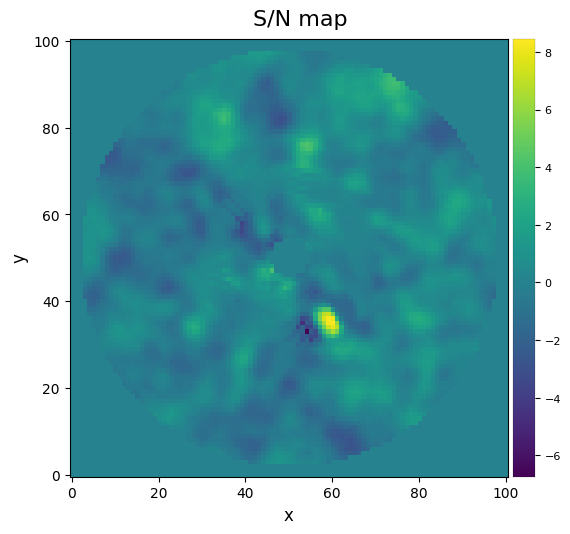

S/N map created using 5 processes
Running time:  0:00:02.721794
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [22]:
snrmap1 = snrmap(fr_pca1, fwhm_naco, plot=True)

Remember that S/N ratio is NOT the same as significance [Mawet et al. 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...792...97M/abstract). Let's convert the measured S/N (Students statistics) into a Gaussian "sigma" with equivalent false alarm probability. This first involves calculating the radial separation of the candidate:

In [23]:
cy, cx = frame_center(snrmap1)
rad = np.sqrt((cy-xy_b[1])**2+(cx-xy_b[0])**2)

Now let's use the `significance` routine in VIP to operate the conversion:

In [24]:
sig1 = significance(snr1, rad, fwhm_naco, student_to_gauss=True)
print(r"{:.1f} sigma detection".format(sig1))

5.4 sigma detection


Congratulations! The detection is significant! You obtained a conspicuous direct image of an exoplanet! Although from this image (at a single wavelength) alone one cannot disentangle a true physically bound companion from a background star, this source has now been extensively studied: it corresponds to the giant planet Beta Pic b (e.g. [Lagrange et al. 2009](https://ui.adsabs.harvard.edu/abs/2009A%26A...493L..21L/abstract), [Absil et al. 2013](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract)).

### 3.5.2. Optimizing the number of PCs for full-frame PCA-ADI

Clearly, modeling the background (leaked starlight + static and quasi-static speckles) with PCA leads to better images than subtracting a median frame. We chose 5 principal components (PCs), which greatly reduced the residual noise. A different number of PCs may lead to an even better detection.

For a given point source, the `pca` function can search for the optimal number of principal components which maximizes the S/N ratio of a given point source. When calling `pca`, this is done by setting `ncomp` to a tuple of 3 integers (initial value, last value, step) setting the range of explored npc values, and providing the `source_xy` coordinates of the point source of interest:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:29:14
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 1.112 GB
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.026285
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 31
Optimal number of PCs = 13, for S/N=9.028
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 58.5, 35.5
Flux in a centered 1xFWHM circular aperture = 114.501
Central pixel S/N = 11.321
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 9.028
Max S/N (shifting the aperture center) = 11.526
stddev S/N (shifting the aperture center) = 2.167



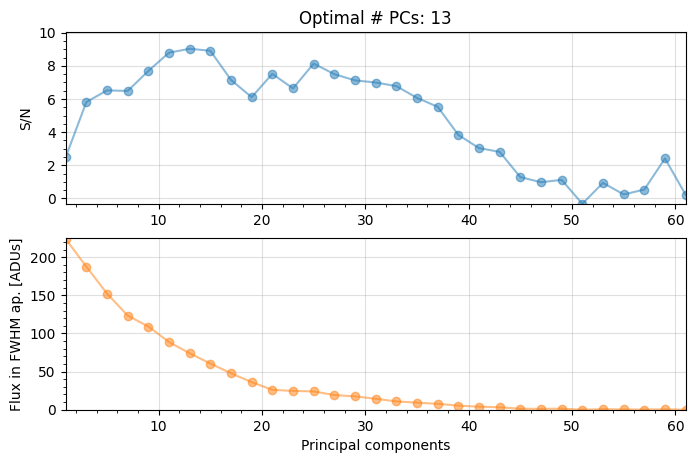

In [25]:
fr_pca2 = pca(cube, angs, fwhm=fwhm_naco, source_xy=xy_b, mask_center_px=None, 
              ncomp=(1, 61, 2), imlib=imlib_rot, interpolation=interpolation)

The optimal number of principal components is found to be 13 (note this value may change slightly if using a different imlib/interpolation, but should be in that ballpark).

In [26]:
ncomp_opt=13

<font color=orange> **Question 3.8**: Why is the shape of the S/N vs Principal components curve as seen above (i.e. increasing and then decreasing again)? </font>

Now let's look at the images computed using 5 PCs and 13 PCs (optimal npc found above), and compute the S/N maps:

In [27]:
snrmap1 = snrmap(fr_pca1, fwhm_naco, plot=False)
snrmap2 = snrmap(fr_pca2, fwhm_naco, plot=False)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:29:50
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 5 processes
Running time:  0:00:02.830185
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:29:53
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 5 processes
Running time:  0:00:02.761397
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


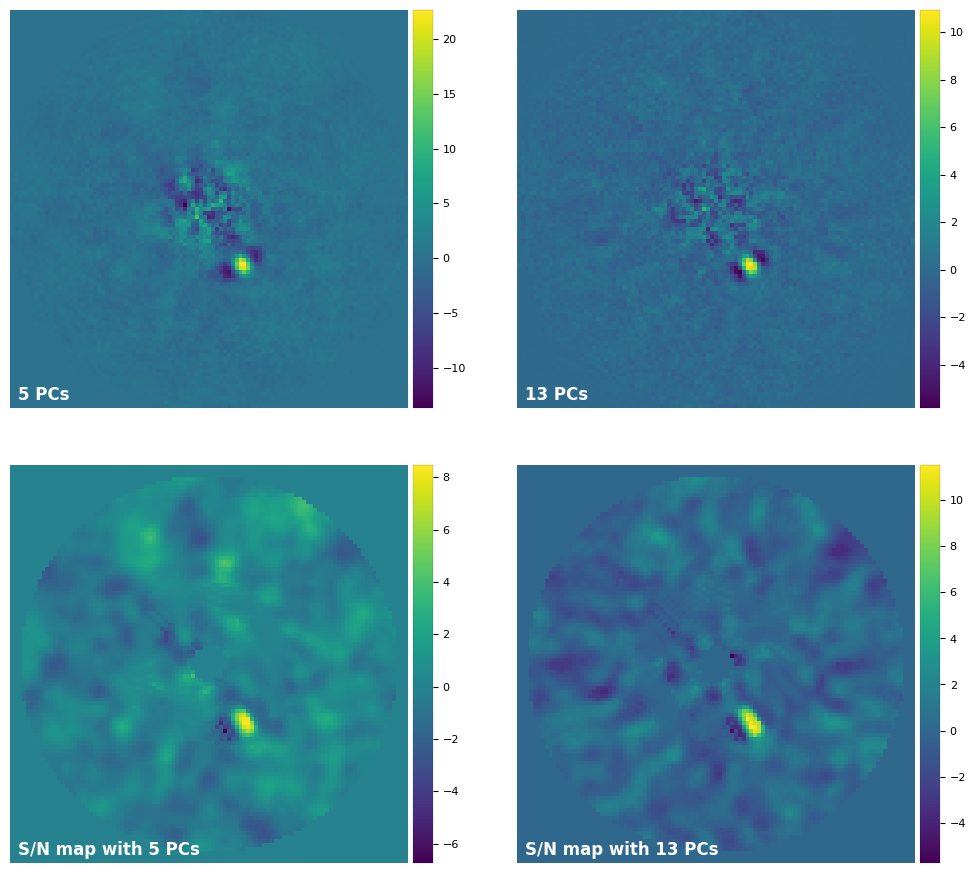

In [28]:
plot_frames((fr_pca1, fr_pca2, snrmap1, snrmap2), rows=2, dpi=100, colorbar=True, axis=False, 
            versp=0.01, horsp=0.2,
            label=('{} PCs'.format(ncomp), '{} PCs'.format(ncomp_opt), 
                   'S/N map with {} PCs'.format(ncomp), 'S/N map with {} PCs'.format(ncomp_opt)), 
            label_pad=8)

With 13 PCs we've increased the S/N of the point source (although the recovered flux is smaller). Let's compare the difference it makes on the significance:

In [29]:
snr2 = snr(fr_pca2, source_xy=xy_b, fwhm=fwhm_naco)
sig2 = significance(snr2, rad, fwhm_naco, student_to_gauss=True)

print(r"S/N = {:.1f} ({} PCs) VS. S/N = {:.1f} ({} PCs)".format(snr1, ncomp, snr2, ncomp_opt))
print(r"{:.1f} sigma detection ({} PCs) VS. {:.1f} sigma detection ({} PCs)".format(sig1, ncomp, sig2, ncomp_opt))

S/N = 8.1 (5 PCs) VS. S/N = 11.3 (13 PCs)
5.4 sigma detection (5 PCs) VS. 6.3 sigma detection (13 PCs)


<font color='orange'> **Question 3.9**: The result above was obtained for the full-frame PCA algorithm. For a given point source (i.e. at a given radius), is the optimal npc expected to be the same for PCA applied in a single annulus (encompassing the point source) and PCA on full frame? If not, would you intuitively expect it to be lower or higher for PCA on a single annulus? </font> 

The answer to Q5.6 will come in [Section 3.5.6](#3.5.6.-PCA-in-a-single-annulus). 

<font color=green> **Answer 3.6**: The negative side lobes stem from the presence of the point source in the constructed model used for subtraction. Since the field of view is rotating, the point source will span a range of position angles, and the stellar halo model built for subtraction for each frame of the cube (step B) will typically include some signal from the rotating point-source. </font>
    
<font color=green> **Answer 3.7**: The negative side lobes are not *necessarily* symmetric, as the field rotation rate (hence the rate at which the point source rotates) varies during the observation. The parallactic angle variation is the fastest when the target crosses the meridian. That being said, well-designed ADI observations typically aim for maximal field rotation, which is the case for an observation that is centered around meridian crossing, hence typically resulting in relatively symmetric negative signatures. </font>

<font color=green> **Answer 3.8**: The S/N first increases with $n_{\rm pc}$ due to a better modeling of the speckle pattern by including more PCs. After reaching the optimal $n_{\rm pc}$, the planet self-subtraction starts to dominate (i.e. a large $n_{\rm pc}$ will systematically lead to overfitting of the stellar PSF). </font>

### 3.5.3. Full-frame PCA-ADI with a parallactic angle threshold

We can partially avoid the companion self-subtraction with full-frame PCA by applying a PA threshold for a given distance from the center. This is more efficient if a lot of rotation is present in the data.

This dataset happens to have a good range of rotation (about ~80 deg), and is therefore suitable for that:

Text(0, 0.5, 'Derotation angles')

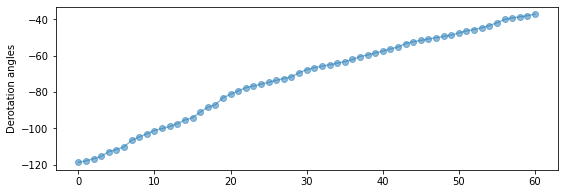

In [30]:
figure(figsize=(9,3))
plot(angs, 'o-', alpha=0.5)
ylabel('Derotation angles')

<font color=orange> **Question 3.10** For a given observatory, where are the most ideal targets (in terms of celestial coordinates) to apply the ADI strategy (i.e. the ones leading to an optimal parallactic angle variation)? </font>

The `pca` function in ``VIP`` accepts a parameter `source_xy` for defining a location of interest for which the rotation threshold will be applied. The parameter `delta_rot` sets the minimum amount of linear motion in terms of the FWHM to include other frames when building the PCA library for each image of the sequence. In the following example we set the threshold to 1 FWHM, which will significantly reduce companion self-subtraction. We also increase the npc to 30.

In [31]:
fr_pca_optlib = pca(cube, angs, ncomp=30, source_xy=xy_b, delta_rot=1, fwhm=fwhm_naco,
                    imlib=imlib_rot, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:29:56
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 1.075 GB
Size LIB: min=30.0 / 1st QU=33.0 / med=39.0 / 3rd QU=44.0 / max=52.0
Done de-rotating and combining
Running time:  0:00:04.147441
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


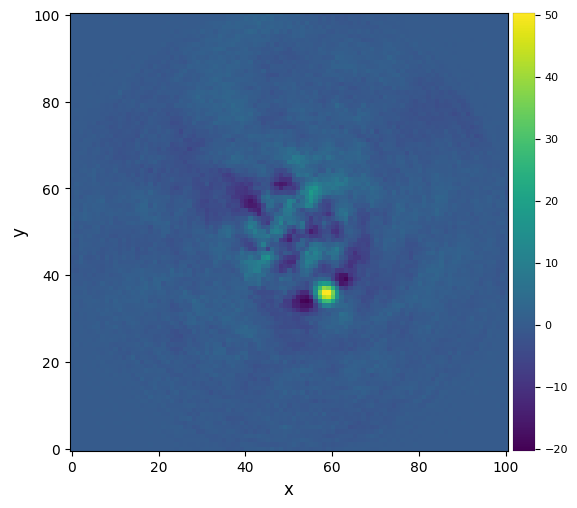

In [32]:
plot_frames(fr_pca_optlib)#, backend='bokeh')

<font color=orange> **Question 3.11**: As can be seen above, a PA threshold reduces the self-subtraction (notice the maximum in the scale), but also leads to a less efficient modeling and subtraction of speckle in the innermost part of the image. 
Why is that so?</font>

We can have a quick report on the last two frames, obtained without and with parallactic angle threshold, and in particular inspect the effect on the flux and S/N ratio of the companion:

In [33]:
snr(fr_pca2, xy_b, fwhm_naco, verbose=True)

S/N for the given pixel = 11.321
Integrated flux in FWHM test aperture = 114.501
Mean of background apertures integrated fluxes = -4.382
Std-dev of background apertures integrated fluxes = 10.260


11.320734961541241

In [34]:
snr(fr_pca_optlib, xy_b, fwhm_naco, verbose=True)

S/N for the given pixel = 7.454
Integrated flux in FWHM test aperture = 538.744
Mean of background apertures integrated fluxes = -26.475
Std-dev of background apertures integrated fluxes = 74.088


7.453634382886601

The companion flux on ``fr_pca_optlib`` is much larger than on ``fr_pca2`` (best full-frame PCA frame without the application of a rotation threshold) because we've reduced self-subtraction (companion over subtraction). On the other hand, the S/N has decreased due to the larger residual speckle noise.

<font color=green> **Answer 3.10** Targets with a declination $\delta$ very different to the latitude $L$ of the observatory will have a very slow parallactic angle variation rate, and are hence not ideal for ADI. On the other extreme, an object whose $\delta$ matches almost exactly $L$ (within a few degrees) will have all the field rotation happening in a matter of minutes, around the time when the object crosses the local meridian (north-south imaginary line) - called transit. This is not ideal either. The best targets for ADI are thus the ones where $|\delta-L|$ is neither too small ($>5$deg) nor too large ($\lesssim 35$deg), as is the case for beta Pic as observed from the Very Large Telescope ($|\delta-L| \approx 27$deg) </font>

<font color=green> **Answer 3.11** Using a PA threshold implies that for a given image to be modeled, the PCA library will be built using exclusively images taken sufficiently far away in time (hence with less correlated speckle). This in turn can lead to a less efficient speckle subtraction. This effect can be particularly stronger in the innermost parts of the image, where a given threshold in terms of linear motion implies a larger delay than for the outer parts of the image. </font>

### 3.5.4. PCA for big datacubes

Computing the PCA model can be a CPU and memory intensive procedure, when working with thousands of large frames, let's say cubes with shapes [10000, 600, 600]. Such cube won't fit on the memory of a normal laptop or desktop computer. With ``VIP`` we just need to provide a positive integer value to the ``batch`` parameter of the ``pca`` function to alleviate this issue. Let's compute the incremental PCA on our toy cube (even if its size does not require it):

In [35]:
fr_increm = pca(cube, angs, ncomp=19, fwhm=fwhm_naco, batch=31, imlib=imlib_rot, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:30:00
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 1.032 GB
Cube size = 0.002 GB (61 frames)
Batch size = 31 frames (0.001 GB)

Batch 1/2	shape: (31, 101, 101)	size: 1.3 MB
Batch 2/2	shape: (30, 101, 101)	size: 1.2 MB
Running time:  0:00:00.201156
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Reconstructing and obtaining residuals
Running time:  0:00:01.368411
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


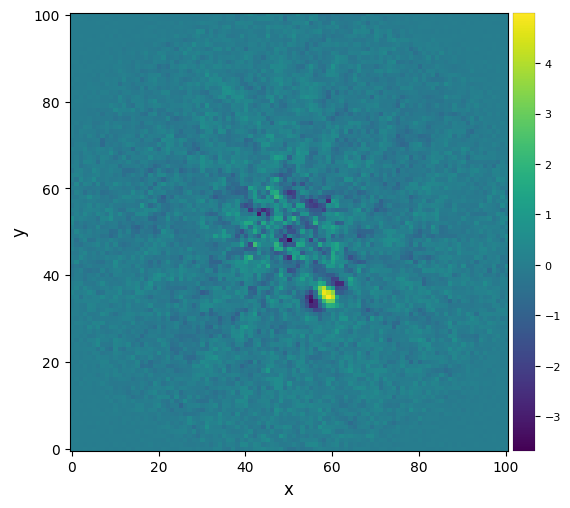

In [36]:
plot_frames(fr_increm)#, backend='bokeh')

### 3.5.5. Annular PCA

PCA can also be performed on concentric annuli, and including a parallactic angle threshold when building the PCA library associated to each image. This is the same idea used before in full-frame when the position of a source of interest was defined except that the PA threshold here will be adjusted depending on the radial distance of each annulus from the star. PCA can be computed in full annuli or in separate annular segments (``n_segments``). The computational cost increases accordingly.

The function `pca_annular` processes the cube in annular fashion in a serial or parallel way. Setting `nproc` to an integer will use that number of CPUs in multiprocessing, while setting it to `None` will automatically set it to half the number of CPUs available on the machine. The improvement in speed is noticeable in multi-core machines. 

Let's try `pca_annular` with 3 segments per annulus, 6 principal components, a 0.2 FWHM rotation threshold, and in multi-processing mode:

In [9]:
pca_ann_obj = PPPcaFF(dataset=betapic,ncomp=6, asize=betapic.fwhm, delta_rot_ann=0.2, nproc=None, 
                          n_segments=3, svd_mode='lapack', imlib=imlib_rot, interpolation=interpolation)
pca_ann_obj.run(runmode='annular')

adimsdi: double
asize: 4.800919383969432
batch: None
check_mem: True
collapse: median
collapse_ifs: mean
conv: False
crop_ifs: True
cube_sig: None
dataset: <vip_hci.dataset.Dataset object at 0x7f1b32339cd0>
delta_rot: 1
delta_rot_ann: 0.2
delta_sep: (0.1, 1)
ifs_collapse_range: all
imlib: vip-fft
imlib2: vip-fft
interpolation: None
mask_center_px: None
mask_rdi: None
max_frames_lib: 200
min_frames_lib: 2
n_segments: 3
ncomp: 6
nproc: None
radius_int: 0
scaling: None
source_xy: None
svd_mode: lapack
theta_init: 0
tol: 0.1
weights: None
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-03-22 15:36:57
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 22.62    Ann center:   2    N segments: 3 
Done PCA with lapack for current annulus
Running time:  0:00:00.050963
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

The parameter `ncomp` can be set to *auto* for letting the algorithm define automatically the number of PCs for each annular patch (instead of fixing it for all of them). The optimal value is found when the standard deviation of the residuals after the subtraction of the PCA approximation drops below a given (absolute) tolerance `tol` while progressively increasing the number of principal components. Note that this is different to finding the optimal $n_{\rm pc}$ that maximizes the S/N ratio of a given companion companion (as the former does not require any companion).

In [38]:
fr_pca_auto = pca_annular(cube, angs, fwhm=fwhm_naco, ncomp='auto', svd_mode='lapack', asize=fwhm_naco, 
                          delta_rot=0.2, tol=0.1, nproc=None, imlib=imlib_rot, interpolation=interpolation, 
                          verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:30:04
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.603
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 22.62    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.075258
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.173753
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  4.58    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.289932
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  3.27    Ann center:  16    N segments: 1 
Done PCA with lapack for curr

Now let's compare both images:

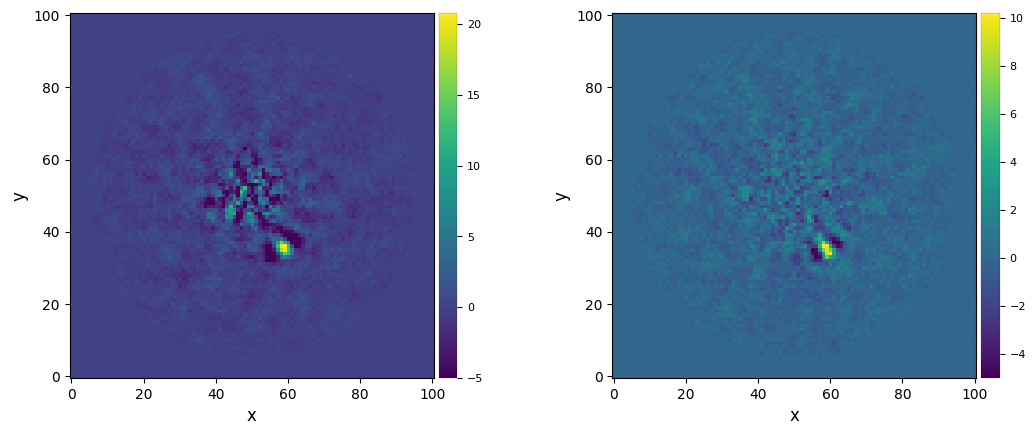

In [39]:
plot_frames((fr_pca_an6, fr_pca_auto), dpi=100, vmin=-5, colorbar=True)

And let's compare the S/N ratio measured in each case: 

In [40]:
snr1 = snr(fr_pca_an6, fwhm=fwhm_naco, source_xy=xy_b, verbose=True)

S/N for the given pixel = 9.401
Integrated flux in FWHM test aperture = 195.983
Mean of background apertures integrated fluxes = -5.573
Std-dev of background apertures integrated fluxes = 20.946


In [41]:
snr2 = snr(fr_pca_auto, fwhm=fwhm_naco, source_xy=xy_b, verbose=True)

S/N for the given pixel = 10.533
Integrated flux in FWHM test aperture = 84.835
Mean of background apertures integrated fluxes = -3.679
Std-dev of background apertures integrated fluxes = 8.211


Despite the relatively high S/N ratio, the planet appears significantly self-subtracted. This is because `delta_rot` was set to a low value. Setting it to a value larger than 0.3 leads to a bug (feel free to test it). This is because for a given image to be modelled, not enough images are found in the rest of the datacube complying with the PA threshold condition for the innermost annuli. To solve this issue, one can increase the radius `radius_int` of the innermost annulus where annular PCA starts.

In [42]:
fr_pca_ann_mask = pca_annular(cube, angs, fwhm=fwhm_naco, ncomp='auto', asize=fwhm_naco, radius_int=5,
                              delta_rot=1, nproc=None, svd_mode='lapack', imlib=imlib_rot, 
                              interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:30:06
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 9, FWHM = 4.603
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 34.99    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.072635
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh: 21.88    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.165516
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh: 15.87    Ann center:  17    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.269982
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh: 12.44    Ann center:  21    N segments: 1 
Done PCA with lapack for curre

When using PCA with a numerical mask covering the inner part of the image, it is recommended to explicitly set the optional argument `mask_val=0` (the value used for missing values not calculated by PCA). This will tell the image (de)rotation algorithm which pixels are part of a mask. These values will then be interpolated before rotation (using a Gaussian kernel size set by `ker`), and masked again after rotation. This will prevent a sharp transition between the mask and the signals near the mask. This sharp transition in the inner part of the image would otherwise lead to either Gibbs-related artefacts (when using the FFT-based rotation method), or ringing artefacts (when using an interpolation-based method). See the difference below. Similar tests are also shown in Tutorial `7. FFT- vs interpolation-based image operations`.

In [43]:
fr_pca_ann_mask0 = pca_annular(cube, angs, fwhm=fwhm_naco, ncomp='auto', asize=fwhm_naco, radius_int=5,
                              delta_rot=1, nproc=None, svd_mode='lapack', imlib=imlib_rot, 
                              interpolation=interpolation, mask_val=0, ker=1)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:30:07
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 9, FWHM = 4.603
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 34.99    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.082763
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh: 21.88    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.188862
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh: 15.87    Ann center:  17    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.297967
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh: 12.44    Ann center:  21    N segments: 1 
Done PCA with lapack for curre

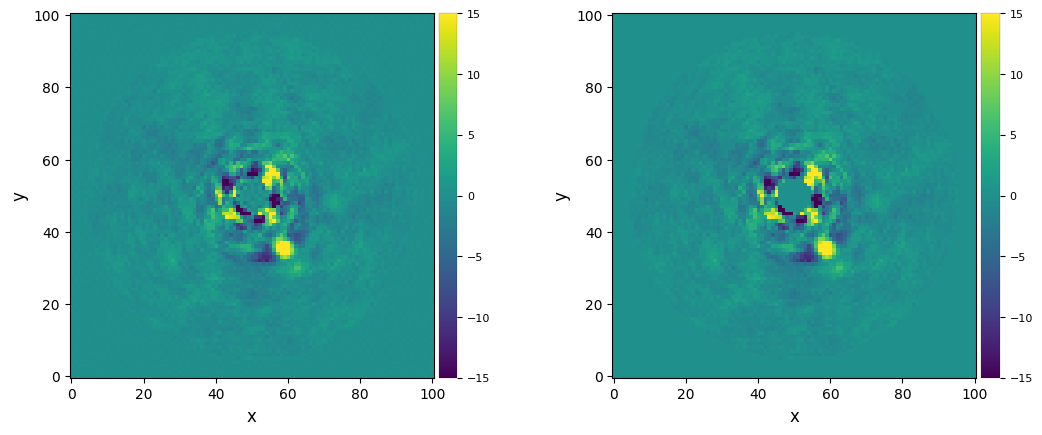

In [44]:
plot_frames((fr_pca_ann_mask, fr_pca_ann_mask0), vmin=-15, vmax=15)

For more flexibility, `delta_rot` can also be set to a tuple of 2 values instead of a scalar. If a tuple, it corresponds to the PA thresholds for the innermost and outermost annuli in the image (linearly interpolated in between).

In [45]:
fr_pca_ddrot = pca_annular(cube, angs, fwhm=fwhm_naco, ncomp='auto', asize=fwhm_naco, delta_rot=(0.2,1), nproc=None, 
                          svd_mode='lapack', imlib=imlib_rot, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:30:09
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.603
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 22.62    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.069465
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh: 11.00    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.162790
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  8.64    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.275536
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  7.63    Ann center:  16    N segments: 1 
Done PCA with lapack for curr

Let's compare with the image obtained with a single PA threshold at all radii.

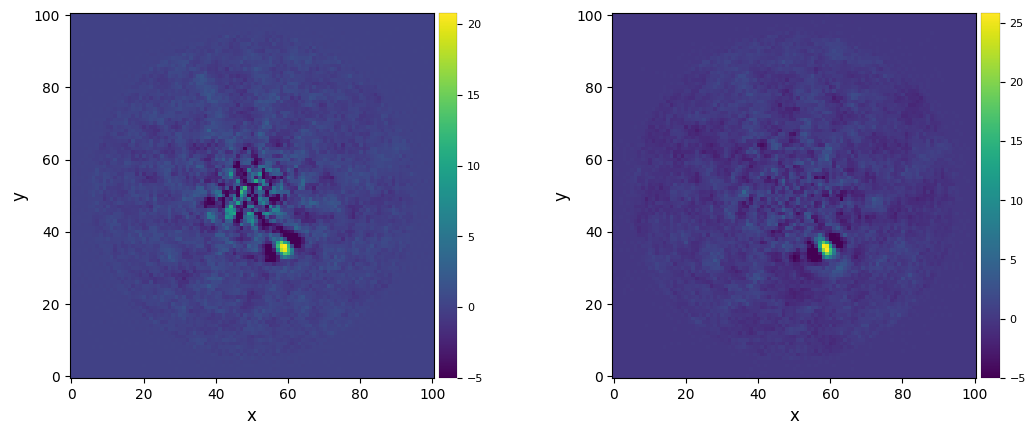

In [46]:
plot_frames((fr_pca_an6, fr_pca_ddrot), dpi=100, vmin=-5, colorbar=True)

The residual speckle noise is now lower in the innermost part of the image.

### 3.5.6. PCA in a single annulus

Once a companion candidate has been identified, the fastest way to recover (and hence characterize) it is to apply PCA on a single annulus encompassing the companion candidate. This is used in particular for the characterization of companion candidates with the negative fake companion technique (see `Tutorial 5. Planet forward modeling`). The relevant function is called `pca_annulus`, which requires the radius `r_guess` of the annulus to be provided, and its `annulus_width`.

In [47]:
ncomp_test = 5
pca_ann_test = pca_annulus(cube, angs, ncomp=ncomp_test, annulus_width=3*fwhm_naco, r_guess=rad,
                           imlib=imlib_rot, interpolation=interpolation)

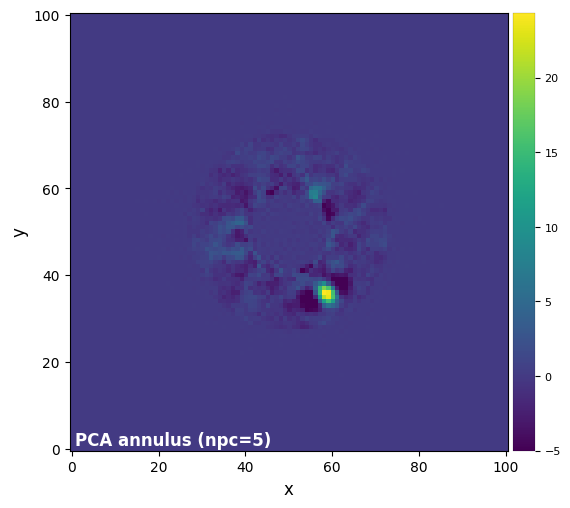

In [48]:
plot_frames(pca_ann_test, label='PCA annulus (npc={:.0f})'.format(ncomp_test),
            dpi=100, vmin=-5, colorbar=True)

Let's now use `pca_grid` to search for the optimal $n_{\rm pc}$ that maximizes the S/N ratio of a given point source. `pca_grid` encompasses both the `pca` and `pca_annulus` function, depending on whether `mode='fullfr'` or `mode='annular'`, respectively. This will allow us to answer Q3.9 we posed earlier: <font color=orange> Is the optimal number of PCs the same for full-frame PCA and PCA in an annulus? </font>

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:30:12
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.114386
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 31
Optimal number of PCs = 13, for S/N=9.028
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 58.5, 35.5
Flux in a centered 1xFWHM circular aperture = 114.501
Central pixel S/N = 11.321
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 9.028
Max S/N (shifting the aperture center) = 11.526
stddev S/N (shifting the aperture center) = 2.167

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:30:47
―――――

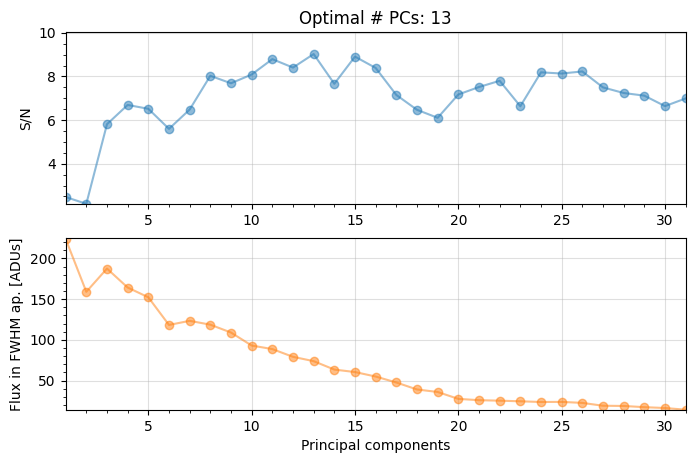

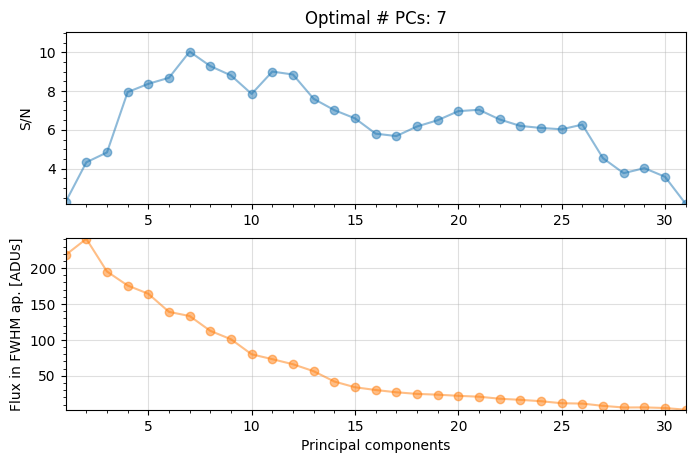

In [49]:
# full frame
res_ff_opt = pca_grid(cube, angs, fwhm=fwhm_naco, range_pcs=(1,31,1), source_xy=xy_b, mode='fullfr', 
                      imlib=imlib_rot, interpolation=interpolation, full_output=True, plot=True)

# single annulus with no PA threshold
res_ann_opt = pca_grid(cube, angs, fwhm=fwhm_naco, range_pcs=(1,31,1), source_xy=xy_b, mode='annular',
                       annulus_width=3*fwhm_naco, imlib=imlib_rot, interpolation=interpolation, 
                       full_output=True, plot=True)

For full-frame PCA the optimal npc is found to be 13 (as already seen in [Sec. 3.5.2](###3.5.2.-Optimizing-the-number-of-PCs-for-full-frame-PCA-ADI)).

For PCA on a single annulus, the optimal npc is found to be 7, hence lower.

Let's plot the final images below. Note that since we ran `pca_grid` with the `full_output=True` option, both final images and optimal number of pcs are returned (among other outputs).

In [50]:
_, final_ff_opt, _, opt_npc_ff = res_ff_opt
_, final_ann_opt, _, opt_npc_ann = res_ann_opt

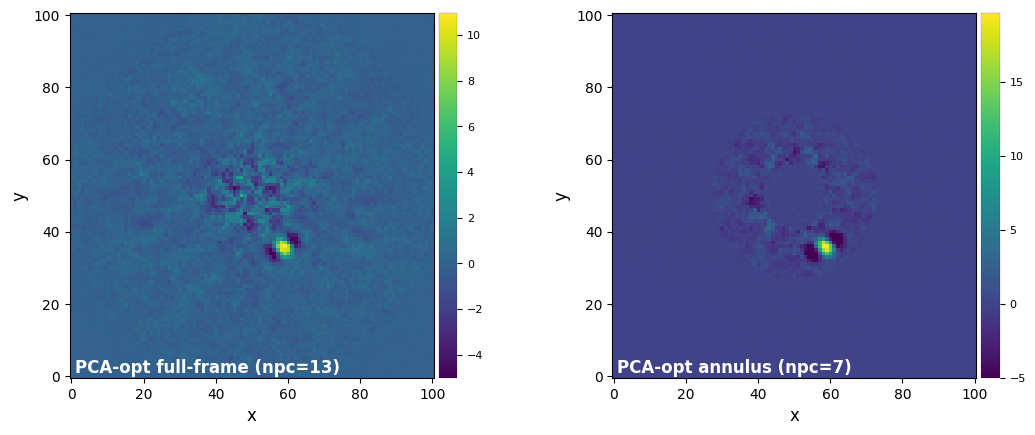

In [51]:
plot_frames((final_ff_opt, final_ann_opt), label=('PCA-opt full-frame (npc={:.0f})'.format(opt_npc_ff), 
                                                  'PCA-opt annulus (npc={:.0f})'.format(opt_npc_ann)),
            dpi=100, vmin=-5, colorbar=True)

<font color='green'> **Answer 5.6**: The optimal $n_{\rm pc}$ is in general lower for PCA on a single annulus than on full frame. Intuitively, one could expect this result due to the smaller number of pixels in the annular case compared to the full frame case. With less pixels (i.e. a smaller matrix for singular value decomposition), a lower $n_{\rm pc}$ is sufficient to achieve similar (or better) modeling of speckle. Conversely a lower $n_{\rm pc}$ would be enough to cause overfitting. </font> 

## 3.6. Non-negative Matrix Factorization (NMF)

A PSF reference can be modelled using a low-rank approximation different than PCA (which relies on singular value decomposition). Non-negative matrix factorization can be used instead ([Gomez Gonzalez et al. 2017](https://ui.adsabs.harvard.edu/abs/2017AJ....154....7G/abstract); [Ren et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...852..104R/abstract)). Instead of $M = U\Sigma V$ (SVD), non-negative matrix factorization can be written as $M = \mathcal{W} \mathcal{H}$, where both matrices are non-negative, and the columns of $\mathcal{H}$ are the non-zero components onto which the images are projected (note that the residuals after model subtraction can be negative though).

The two matrices are typically found iteratively. Currently, the default method in VIP is based on the `scikit-learn` implementation of NMF, which uses the principal components obtained by SVD as first guess of the iterative process. Therefore, the results can look fairly similar to PCA, in particular if the PCs are mostly non-negative.

### 3.6.1. Full-frame NMF

Full-frame NMF is simply done by calling the `nmf` function. Input arguments are mostly similar to `pca`, apart from `init_svd` which sets the method used to estimate the initial SVD from which the solution is iteratively found.

No changes were made to the dataset.
The following parameters will be used for the run of nmf :
- verbose : True
- ncomp : 14
- scaling : None
- max_iter : 10000
- random_state : None
- mask_center_px : None
- source_xy : None
- delta_rot : 1
- init_svd : nndsvdar
- collapse : median
- handle_neg : mask
- nmf_args : {}
- cube : np.ndarray (not shown)
- angle_list : np.ndarray (not shown)
- fwhm : 4.800919383969432
- cube_ref : None
- full_output : True
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-03-24 14:27:24
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:07.677987
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done NMF with sklearn.NMF.
Running time:  0:00:07.714932
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done derotating and combining.
Running time:  0:00:10.342432
――――――――――――――――――――――――――――――――――――

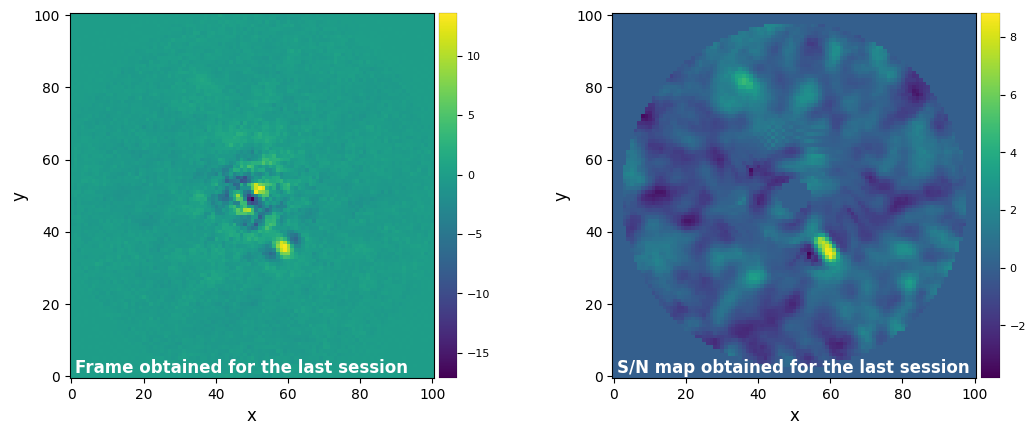

Configuration loaded :
- verbose : True
- ncomp : 14
- scaling : None
- max_iter : 10000
- random_state : None
- mask_center_px : None
- source_xy : None
- delta_rot : 1
- init_svd : nndsvdar
- collapse : median
- handle_neg : mask
- nmf_args : {}
- fwhm : 4.800919383969432
- cube_ref : None
- full_output : True


In [21]:
nmf_obj = NMFBuilder(dataset=betapic, ncomp=14, max_iter=10000, init_svd='nndsvdar', mask_center_px=None, imlib=imlib_rot, 
             interpolation=interpolation, results=results).build()
nmf_obj.run()
nmf_obj.make_snrmap()
results.show_session_results()
nmf_obj.get_params_from_results(session_id=-1)

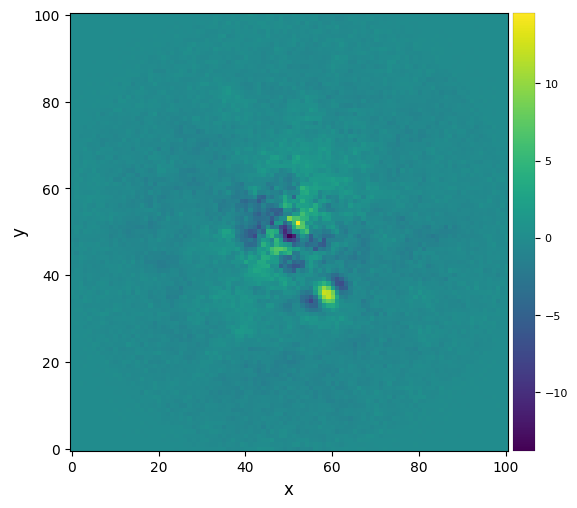

In [53]:
plot_frames(fr_nmf, dpi=100, colorbar=True)#, backend='bokeh')

In [54]:
snr_nmf = snr(fr_nmf, fwhm=fwhm_naco, source_xy=xy_b, verbose=True)

S/N for the given pixel = 6.454
Integrated flux in FWHM test aperture = 120.744
Mean of background apertures integrated fluxes = -2.919
Std-dev of background apertures integrated fluxes = 18.722


### 3.6.2. Annular NMF

The same as above can be performed in concentric annuli (new since v1.0.0):

In [55]:
fr_nmf_ann = nmf_annular(cube, angs, ncomp=9, max_iter=10000, init_svd='nndsvdar', radius_int=0, nproc=None,
                         fwhm=fwhm_naco, asize=fwhm_naco, imlib=imlib_rot, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:31:28
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.603
NMF per annulus (or annular sectors):
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 1 
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Ann 3    PA thresh:  6.87    Ann center:  12    N segments: 1 
Ann 4    PA thresh:  6.54    Ann center:  16    N segments: 1 
Ann 5    PA thresh:  6.36    Ann center:  21    N segments: 1 
Ann 6    PA thresh:  6.24    Ann center:  25    N segments: 1 
Ann 7    PA thresh:  6.16    Ann center:  30    N segments: 1 
Ann 8    PA thresh:  6.11    Ann center:  35    N segments: 1 
Ann 9    PA thresh:  6.06    Ann center:  39    N segments: 1 
Ann 10    PA thresh:  6.17    Ann center:  43    N segments: 1 
Done derotating and combining.
Running time:  0:00:15.829312
―――――――――――――――――――――――――――――――――――――――――――――

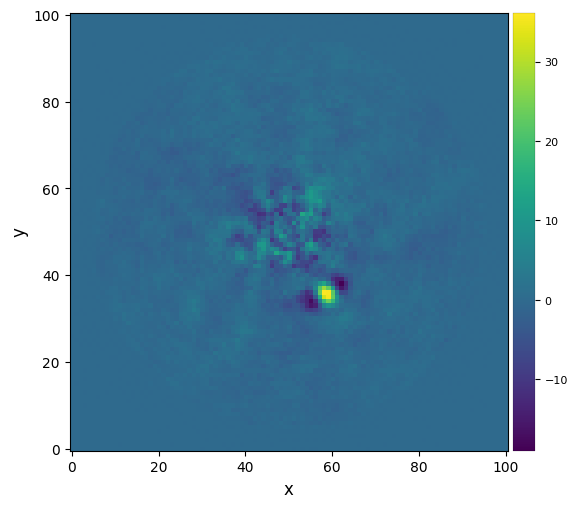

In [56]:
plot_frames(fr_nmf_ann, dpi=100, colorbar=True)

In [57]:
snr_nmf_ann = snr(fr_nmf_ann, fwhm=fwhm_naco, source_xy=xy_b, verbose=True)

S/N for the given pixel = 8.379
Integrated flux in FWHM test aperture = 363.671
Mean of background apertures integrated fluxes = -13.543
Std-dev of background apertures integrated fluxes = 43.986


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:31:44
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


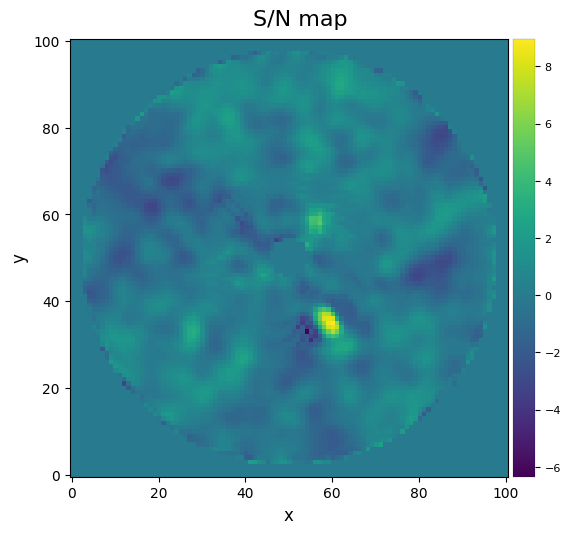

S/N map created using 5 processes
Running time:  0:00:02.770179
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [58]:
snrmap_nmf_ann = snrmap(fr_nmf_ann, fwhm_naco, plot=True)

## 3.7. Local Low-rank plus Sparse plus Gaussian-noise decomposition (LLSG)

Local Low-rank plus Sparse plus Gaussian-noise decomposition (LLSG; [Gomez Gonzalez et al. 2016](https://ui.adsabs.harvard.edu/abs/2016A%26A...589A..54G/abstract)) proposes a three terms decomposition to improve the detectability of point-like sources in ADI data. It aims at decomposing ADI cubes into L+S+G (low-rank, sparse and Gaussian noise) terms. Separating the noise from the S component (where the moving planet should stay) allows us to increase the S/N of potential planets.

Let's try it out:

No changes were made to the dataset.
The following parameters will be used for the run of llsg :
- verbose : True
- rank : 5
- thresh : 1
- max_iter : 20
- low_rank_ref : False
- low_rank_mode : svd
- auto_rank_mode : noise
- residuals_tol : 0.1
- cevr : 0.9
- thresh_mode : soft
- nproc : 1
- asize : None
- n_segments : 4
- azimuth_overlap : None
- radius_int : None
- random_seed : 10
- high_pass : None
- collapse : median
- cube : np.ndarray (not shown)
- angle_list : np.ndarray (not shown)
- fwhm : 4.800919383969432
- full_output : True
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-03-24 14:45:14
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Annuli = 5
Processing annulus: 
1 : in_rad=0, n_segm=4
2 : in_rad=10, n_segm=4
3 : in_rad=20, n_segm=4
4 : in_rad=30, n_segm=4
5 : in_rad=40, n_segm=4

Running time:  0:00:12.175320
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

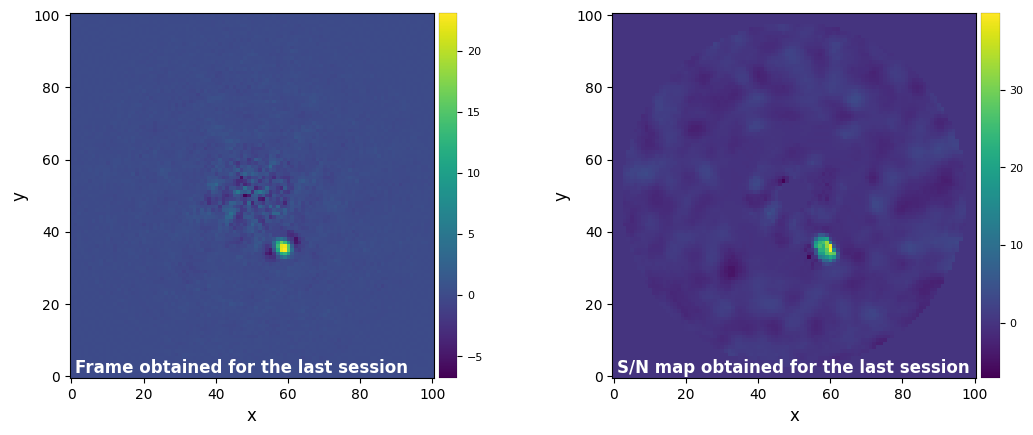

Configuration loaded :
- verbose : True
- rank : 5
- thresh : 1
- max_iter : 20
- low_rank_ref : False
- low_rank_mode : svd
- auto_rank_mode : noise
- residuals_tol : 0.1
- cevr : 0.9
- thresh_mode : soft
- nproc : 1
- asize : None
- n_segments : 4
- azimuth_overlap : None
- radius_int : None
- random_seed : 10
- high_pass : None
- collapse : median
- fwhm : 4.800919383969432
- full_output : True


ValueError: The function used for that session does not match your object. Please choose a session with a corresponding function.

In [20]:
llsg_obj = LLSGBuilder(dataset=betapic, rank=5, thresh=1, max_iter=20, random_seed=10, results=results).build()
llsg_obj.run(imlib=imlib_rot, interpolation=interpolation)
llsg_obj.make_snrmap()
results.show_session_results()
llsg_obj.get_params_from_results(session_id=-1)

Let's plot it along the full-frame PCA-ADI result, after the optimization of the number of PCs:

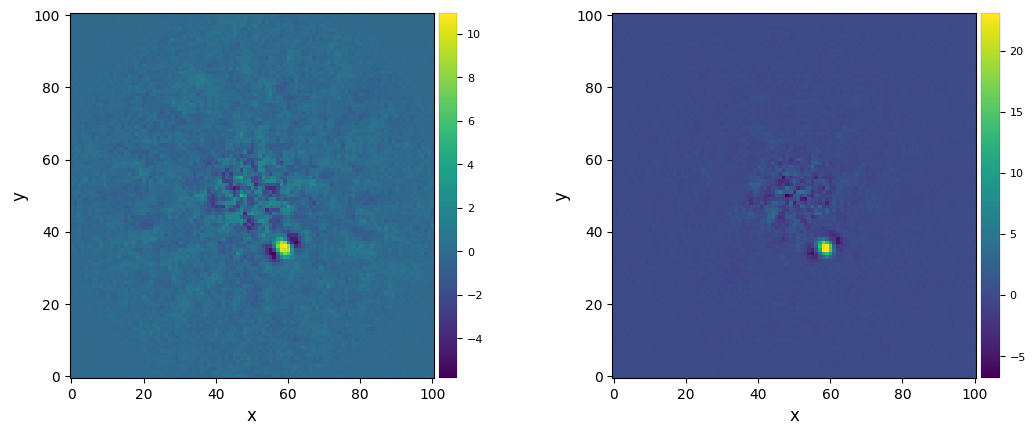

In [60]:
plot_frames((final_ff_opt, fr_llsg))#, backend='bokeh')

The computation of S/N ratio and S/N maps when the noise has been almost totally supressed becomes problematic (both from a theoretical and computational points of view). Let's nevertheless compute them for reference:

In [61]:
snr_llsg = snr(fr_llsg, fwhm=fwhm_naco, source_xy=xy_b, verbose=True)

S/N for the given pixel = 28.185
Integrated flux in FWHM test aperture = 225.660
Mean of background apertures integrated fluxes = -1.612
Std-dev of background apertures integrated fluxes = 7.878


――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:31:50
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


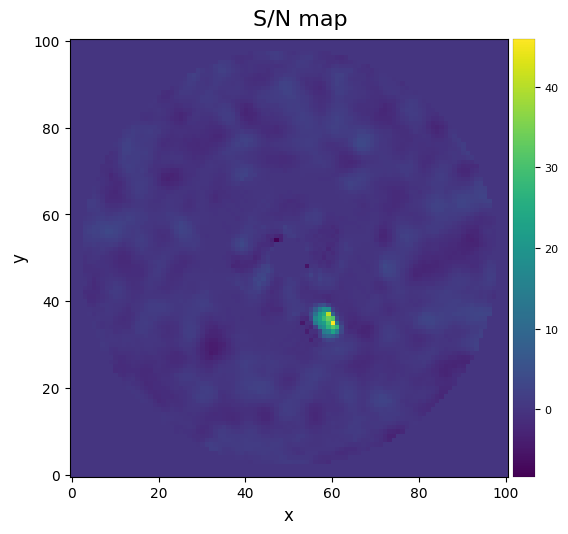

S/N map created using 5 processes
Running time:  0:00:02.766376
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [62]:
snrmap_llsg = snrmap(fr_llsg, fwhm_naco, plot=True)

## 3.8. ANgular Differential OptiMal Exoplanet Detection Algorithm (ANDROMEDA)

Another approach to find point sources in ADI sequences consists in i) subtracting pairs of images separated by a known amount of rotation (typically 0.5 FWHM to produce a specific positive-negative signature); ii) find this residual signature using a maximum match-filter; iii) evaluate the likelihood that a point source is present at each pixel and the corresponding photometry. 
This is what ANDROMEDA does ([Mugnier et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009JOSAA..26.1326M/abstract), [Cantalloube et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015A%26A...582A..89C/abstract)). The principle is summarized in this figure:

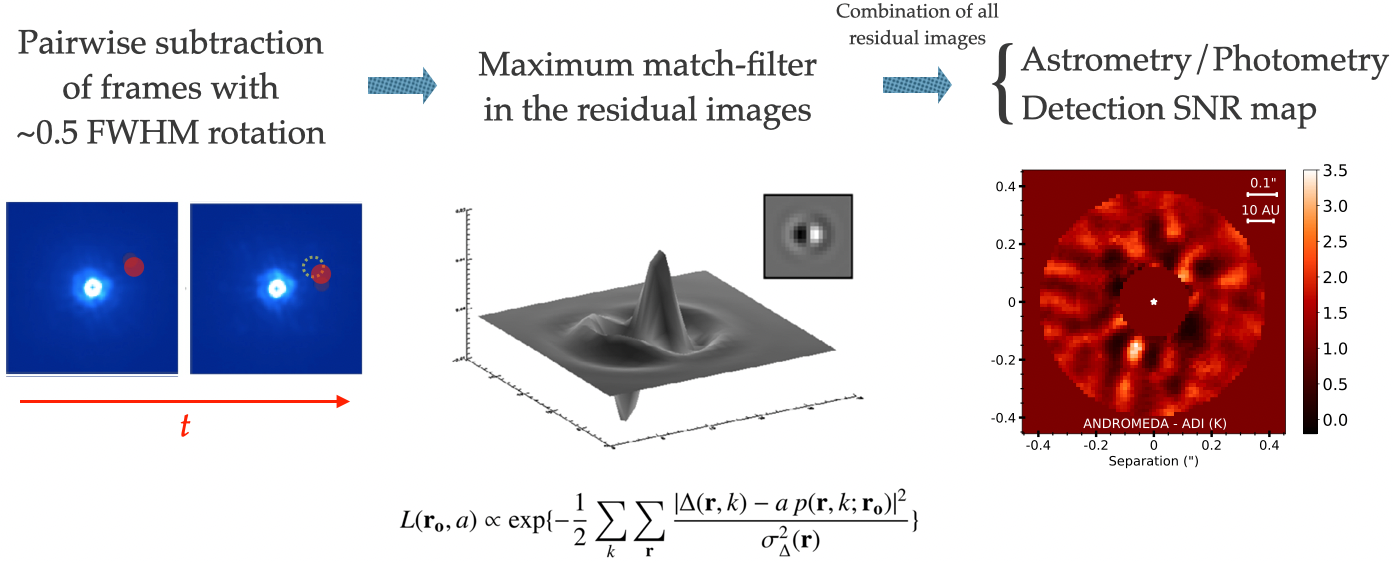

ANDROMEDA follows an inverse-problem approach since it involves a model for the expected positive-negative signature of a point source, and finding the optimal coefficients which minimize residuals between model and observed residual images.

The `andromeda` function in VIP requires the calculation of the oversampling factor (i.e. ratio between Nyquist sampling and actual pixel sampling):

In [63]:
lbda = VLT_NACO['lambdal']
diam = VLT_NACO['diam']
resel = (lbda/diam)*206265 # lambda/D in arcsec
nyquist_samp = resel/2.
oversamp_fac = nyquist_samp/pxscale_naco
oversamp_fac

1.7577458534791308

Let's now try it:

In [64]:
res = andromeda(cube, oversamp_fac, angs, psf, filtering_fraction=.25,
              min_sep=.5, annuli_width=1., roa=2, opt_method='lsq',
              nsmooth_snr=18, iwa=2, owa=None, precision=50, fast=False, 
              homogeneous_variance=True, ditimg=1.0, ditpsf=None, tnd=1.0,
              total=False, multiply_gamma=True, nproc=1, verbose=False)

In [65]:
flux, snr, snr_norm, stdcontrast, stdcontrast_norm, likelihood, ext_radius = res

One can then plot the SNR and flux of a putative companion at each pixel:

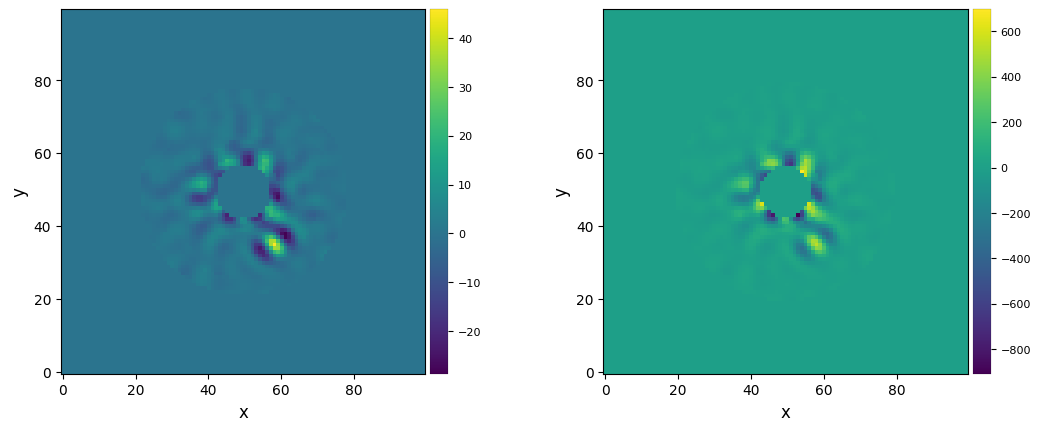

In [66]:
plot_frames((snr_norm, flux))#, backend='bokeh')

## 3.9. Forward-Model Matched Filter (FMMF)

Let's now test the forward-model matched filter (FMMF) with both LOCI and KLIP ([Pueyo 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...824..117P/abstract); [Ruffio et al. 2017](https://ui.adsabs.harvard.edu/abs/2017ApJ...842...14R/abstract); [Dahlqvist et al. 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...646A..49D/abstract)):

In [67]:
if version.parse(vvip) >= version.parse("1.2.4"):
    loci_fmmf_f, loci_fmmf_snr = fmmf(cube, angs, psf, fwhm_naco, model='LOCI', var='FR', nproc=None,
                                      min_r = int(2*fwhm_naco), max_r = int(6*fwhm_naco),
                                      param={'ncomp': 10, 'tolerance': 0.005, 'delta_rot': 0.5},
                                      crop=5, imlib=imlib_rot, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:31:58
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Radial distance 9 done!
Radial distance 11 done!
Radial distance 10 done!
Radial distance 12 done!
Radial distance 13 done!
Radial distance 14 done!
Radial distance 15 done!
Radial distance 16 done!
Radial distance 17 done!
Radial distance 18 done!
Radial distance 19 done!
Radial distance 20 done!
Radial distance 21 done!
Radial distance 22 done!
Radial distance 23 done!
Radial distance 24 done!
Radial distance 25 done!
Radial distance 26 done!
Running time:  0:09:43.078826
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [68]:
if version.parse(vvip) >= version.parse("1.2.4"):
    klip_fmmf_f, klip_fmmf_snr = fmmf(cube, angs, psf, fwhm_naco, model='KLIP', var='FR', nproc=None,
                                      min_r = int(2*fwhm_naco), max_r = int(6*fwhm_naco),
                                      param={'ncomp': 10, 'tolerance': 0.005, 'delta_rot': 0.5},
                                      crop=5, imlib=imlib_rot, interpolation=interpolation)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:41:42
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Radial distance 9 done!
Radial distance 11 done!
Radial distance 10 done!
Radial distance 12 done!
Radial distance 13 done!
Radial distance 14 done!
Radial distance 15 done!
Radial distance 16 done!
Radial distance 17 done!
Radial distance 18 done!
Radial distance 19 done!
Radial distance 20 done!
Radial distance 21 done!
Radial distance 22 done!
Radial distance 23 done!
Radial distance 24 done!
Radial distance 25 done!
Radial distance 26 done!
Running time:  0:10:14.201550
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


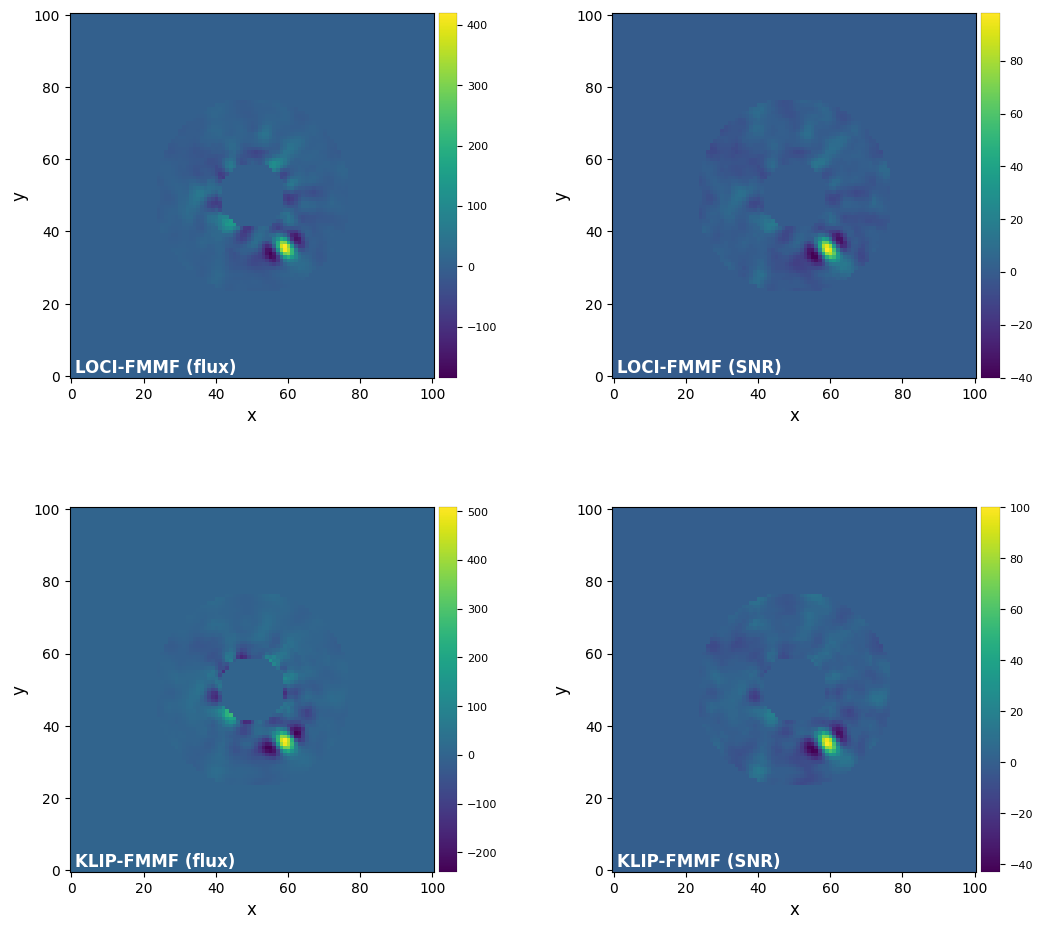

In [69]:
if version.parse(vvip) >= version.parse("1.2.4"):
    plot_frames((loci_fmmf_f, loci_fmmf_snr, klip_fmmf_f, klip_fmmf_snr), rows=2, 
                 label=('LOCI-FMMF (flux)', 'LOCI-FMMF (SNR)','KLIP-FMMF (flux)','KLIP-FMMF (SNR)'))#, backend='bokeh')

## 3.10. Patch Covariances (PACO)

The PAtch COvariances (PACO) algorithm was introduced by [Flasseur et al. (2009)](https://ui.adsabs.harvard.edu/abs/2018A%26A...618A.138F/abstract). It provides a method for extracting the faint signal of the exoplanet from the background noise by building up an empirical model of the background noise. The motion of the planet through the ADI frame is used to identify statistically significant point sources within the field of view. Finally, the flux of the planet can be estimated using an iterative fitting procedure.

Two versions of the PACO algorithm are implemented. While the FullPACO method is more statistically robust, FastPACO produces adequate results in a much shorter time, and has been parallelised using the multiprocessing library.

In [70]:
if version.parse(vvip) >= version.parse("1.2.4"):
    paco = FastPACO(cube=cube, angles=angs, psf = psf, dit_psf = 1.0, dit_science = 1.0, nd_transmission = 1.0,
                    fwhm=pxscale_naco*fwhm_naco,#PACO takes the fwhm in arcsec
                    pixscale = pxscale_naco, rescaling_factor = 1.0, verbose = True)
    paco_snr, paco_flux = paco.run(cpu = cpu_count()//2)

---------------------- 
Summary of PACO setup: 

Image Cube shape = (61, 101, 101)
PIXSCALE = 0.02719
PSF |  Area  |  Rad   |  Width | 
    |   49   |  04    |  039   | 
Patch width: 11
---------------------- 

Precomputing Statistics using 5 Processes...
FWHM: 4.876
Flux in 1xFWHM aperture: 1.338
Running Fast PACO...
Done


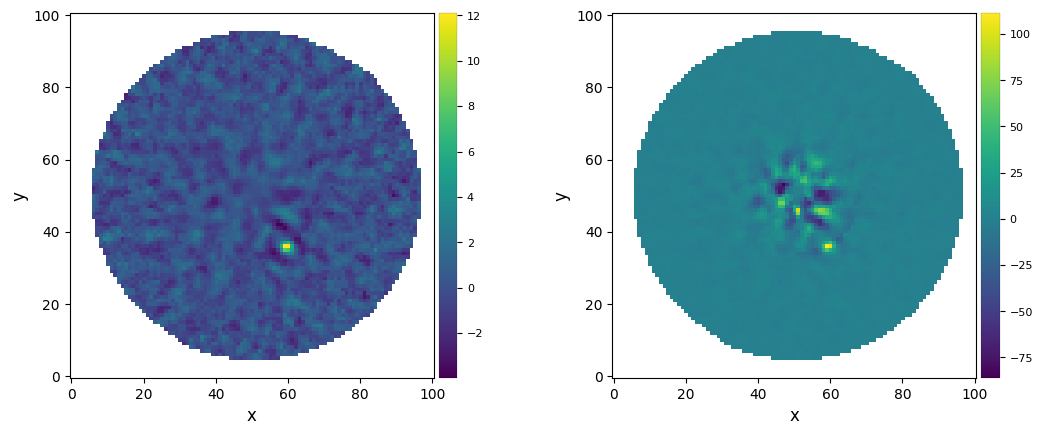

In [71]:
if version.parse(vvip) >= version.parse("1.2.4"):
    plot_frames((paco_snr, paco_flux), label=("PACO SNR", "PACO flux"))

We can now estimate the flux from the snr map.

In [72]:
if version.parse(vvip) >= version.parse("1.2.4"):
    sources = paco.subpixel_threshold_detect(paco_snr, threshold = 5.0) #Threshold in sigma
    posns = [(sources[entry]['x'], sources[entry]['y']) for entry in sources]
    initial_guesses = [paco_flux[int(s[0]),int(s[1])] for s in posns]
    flux_estimates = paco.flux_estimate(posns,eps = 0.1, initial_est = initial_guesses)

Blobs found: 1
 ycen   xcen
------ ------
35.809 	 59.507

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
X,Y = (59.5,35.8)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 59.5, 35.8
Flux in a centered 1xFWHM circular aperture = 77.149
Central pixel S/N = 8.785
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 6.204
Max S/N (shifting the aperture center) = 8.809
stddev S/N (shifting the aperture center) = 1.639

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Computing unbiased flux estimate...
Initial guesses:
Positions:  [(59.50743857609105, 35.80875467973141)]
Contrasts:  [1.7155835246740885]
FWHM: 4.876
Flux in 1xFWHM aperture: 1.338
Precomputing Statistics...
114.35862566624024
Contrast estimate: [109.97867044]
Contrast estimate: [107.82367

## 3.11. Summary mosaic

Let's take a look at the final residual frames produced by the different algorithms:

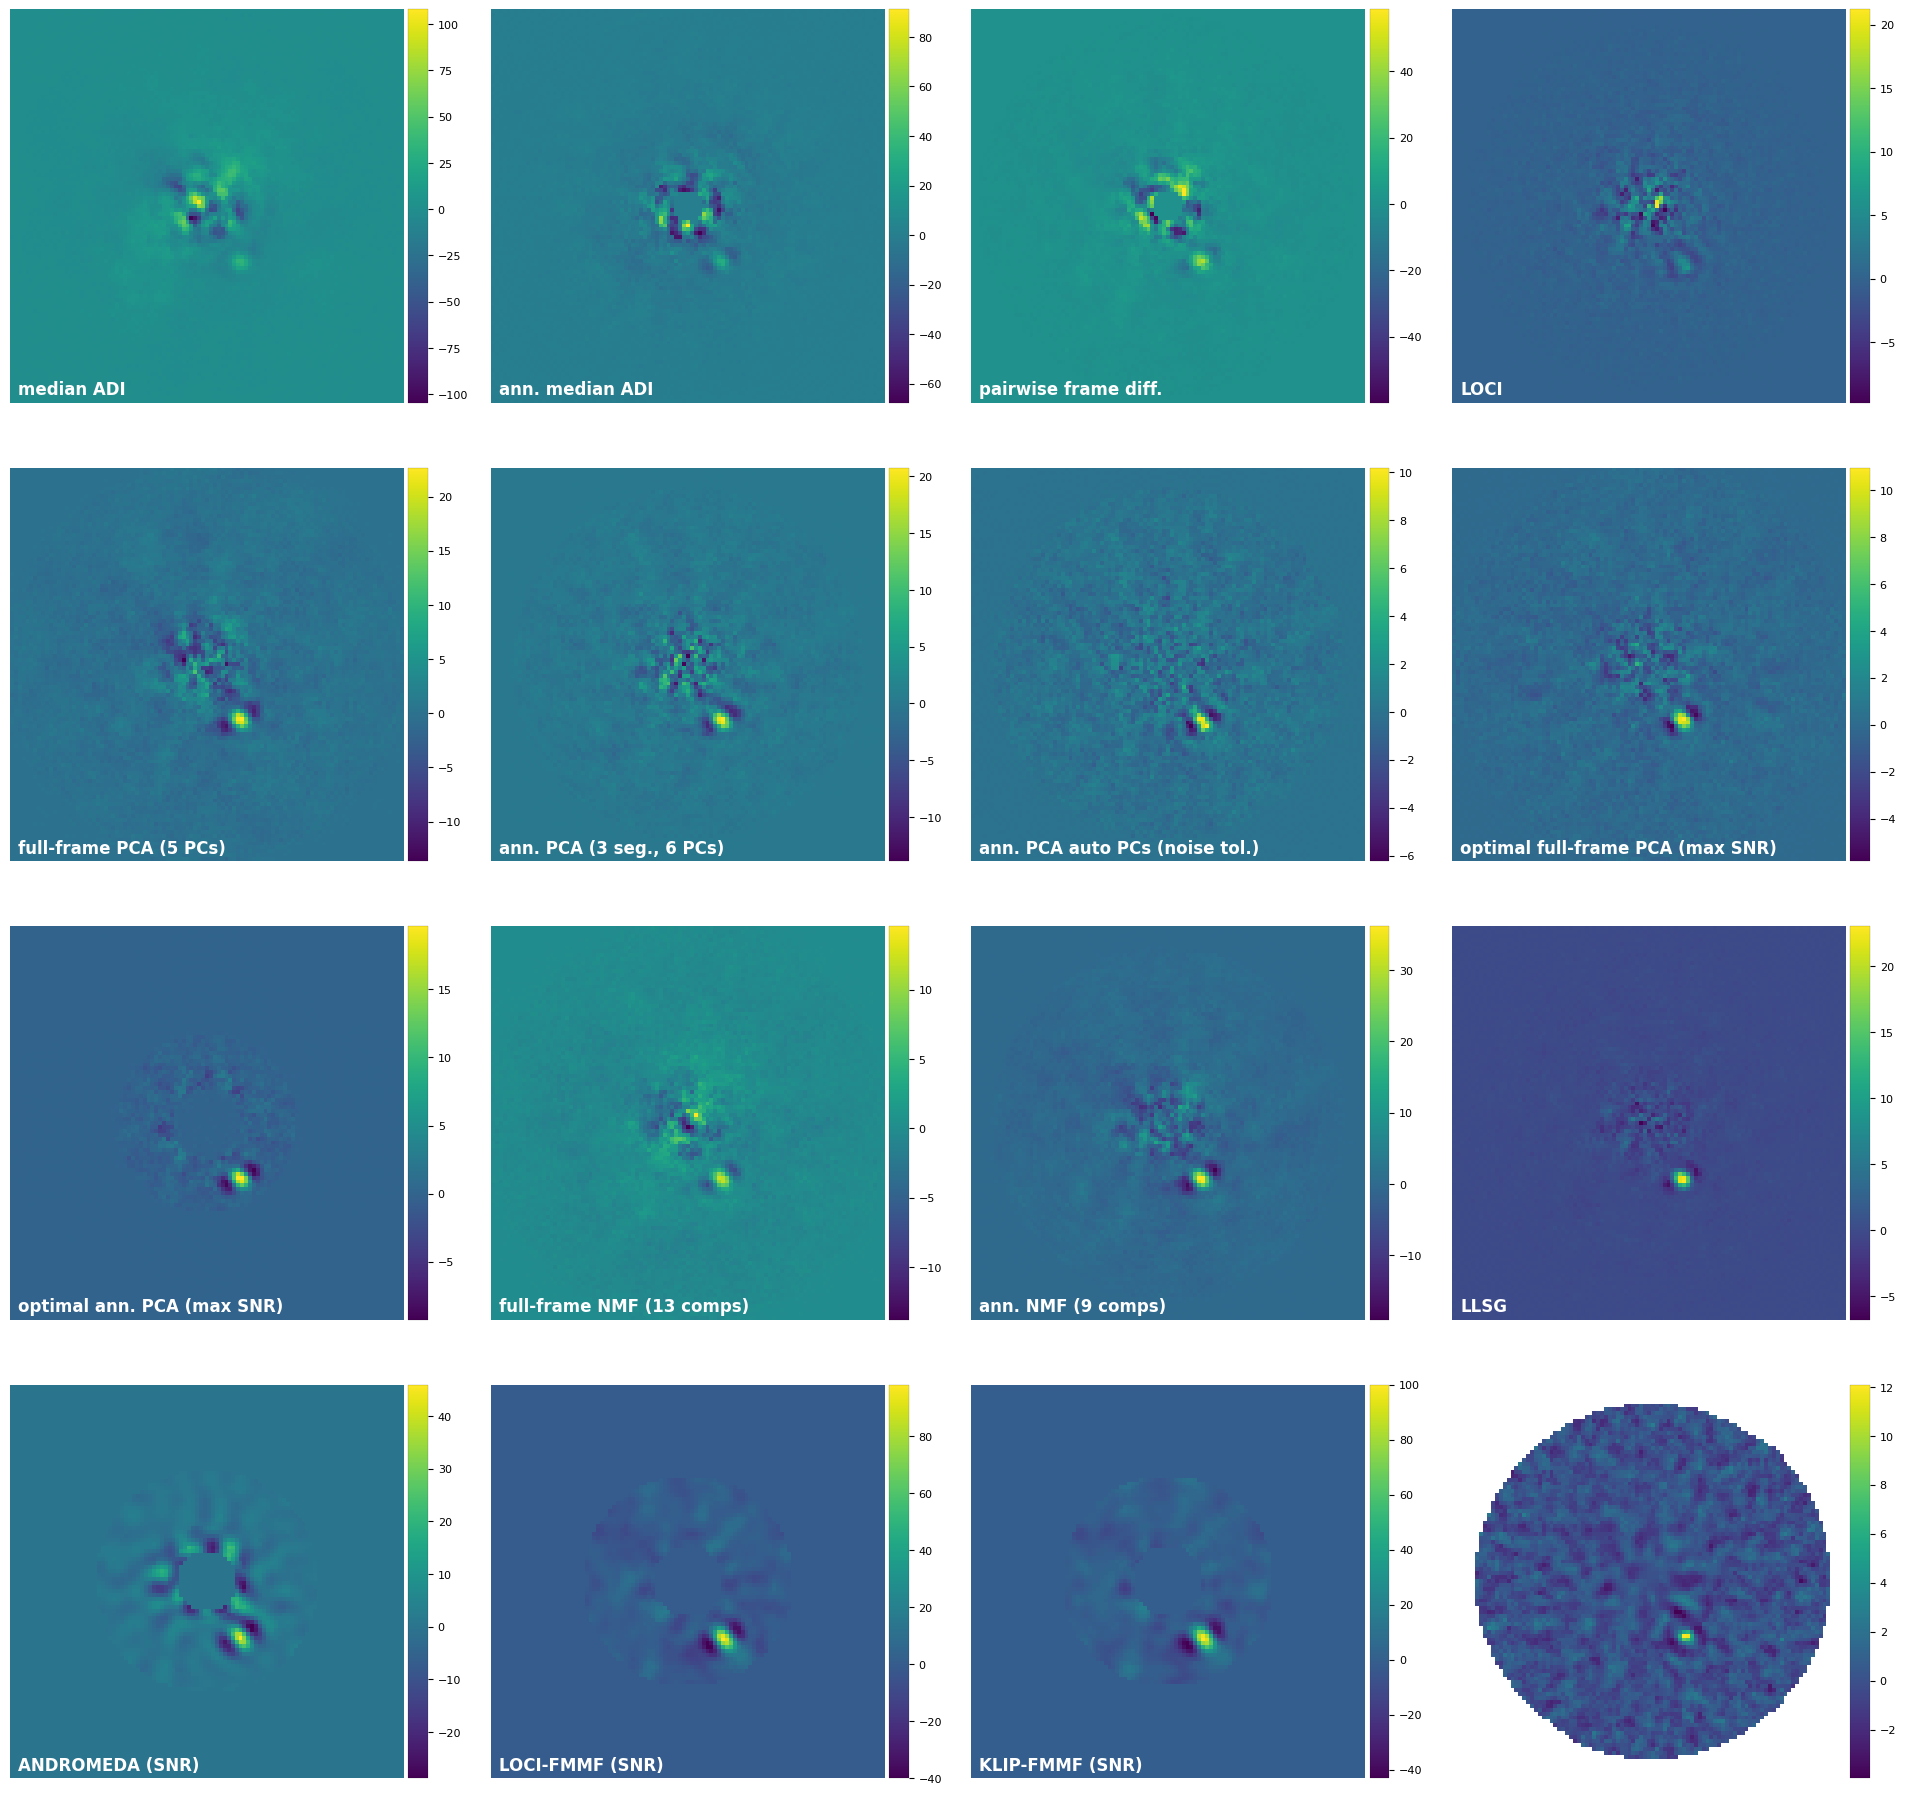

In [73]:
if version.parse(vvip) <= version.parse("1.2.3"):
    plot_frames((fr_adi, fr_adi_an, fr_fdiff, fr_lstsq, fr_pca1, fr_pca_an6, 
                 fr_pca_auto, final_ff_opt, final_ann_opt, fr_nmf, fr_nmf_ann, 
                 fr_llsg, snr_norm), 
                rows=3, colorbar=True, label_size=12, label_pad=8, axis=False, versp=0.05, horsp=0.15, 
                label=('median ADI', 'ann. median ADI', 'pairwise frame diff.', 'LOCI', 
                       'full-frame PCA (5 PCs)', 'ann. PCA (3 seg., 6 PCs)', 
                       'ann. PCA auto PCs (noise tol.)', 'optimal full-frame PCA (max SNR)', 
                       'optimal ann. PCA (max SNR)', 'full-frame NMF (13 comps)', 'ann. NMF (9 comps)',
                       'LLSG', 'ANDROMEDA (SNR)'))
else:
    plot_frames((fr_adi, fr_adi_an, fr_fdiff, fr_lstsq, fr_pca1, fr_pca_an6, 
                 fr_pca_auto, final_ff_opt, final_ann_opt, fr_nmf, fr_nmf_ann, 
                 fr_llsg, snr_norm, loci_fmmf_snr, klip_fmmf_snr, paco_snr), 
                rows=4, colorbar=True, label_size=12, label_pad=8, axis=False, versp=0.05, horsp=0.15, 
                label=('median ADI', 'ann. median ADI', 'pairwise frame diff.', 'LOCI', 
                       'full-frame PCA (5 PCs)', 'ann. PCA (3 seg., 6 PCs)', 
                       'ann. PCA auto PCs (noise tol.)', 'optimal full-frame PCA (max SNR)', 
                       'optimal ann. PCA (max SNR)', 'full-frame NMF (13 comps)', 'ann. NMF (9 comps)',
                       'LLSG', 'ANDROMEDA (SNR)', 'LOCI-FMMF (SNR)', 'KLIP-FMMF (SNR)', 'PACO (SNR)'))

Check out tutorial `4. Metrics` for more details on evaluating i) the significance of a potential point source, ii) the achieved contrast in your image, in the form of contrast curves.